This notebook is a *heavily* adapted version of `Zebrafish-Muscles-Volumetry-5268_5269.ipynb`, specifically for the talk at the Institute seminar in 2024.

In [205]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import scipy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask.array
import dask_image.imread
import dask_image.ndfilters
from numcodecs import Blosc
import skimage
import statsmodels
import scipy.signal
import sklearn.cluster
from skimage.segmentation import random_walker
from skimage.filters import threshold_multiotsu

In [206]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
import tempfile
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})
print('Dask temporary files to to %s' % dask.config.get('temporary_directory'))

Dask temporary files to to /media/habi/Fast_SSD/tmp


In [207]:
from dask.distributed import Client
client = Client()

/home/habi/anaconda3/envs/seminar24/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39453 instead
  warnings.warn(


In [208]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39453/status,
Dashboard: http://127.0.0.1:39453/status,Workers: 8
Total threads: 32,Total memory: 125.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43009,Workers: 8
Dashboard: http://127.0.0.1:39453/status,Total threads: 32
Started: Just now,Total memory: 125.79 GiB
Comm: tcp://127.0.0.1:44543,Total threads: 4
Dashboard: http://127.0.0.1:45171/status,Memory: 15.72 GiB
Nanny: tcp://127.0.0.1:35895,


In [209]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:39453/status"


In [210]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [211]:
# Set up figure defaults for the talk
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['savefig.transparent'] = True
# Set seaborn theme
seaborn.set_theme(
    context='talk',
    style='whitegrid',
)
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation

In [212]:
# Display all plots identically
lines = 2
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [213]:
Root = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD', 'Zebrafish_Carolina_Muscles')
print('We are loading all the data from %s' % Root)

We are loading all the data from /media/habi/Fast_SSD/Zebrafish_Carolina_Muscles


In [214]:
# Make directory for output
# For these notebooks, we simply dump the images one directory up into the relevant 'media' folder
OutPutDir = os.path.join('..', 'media', 'cox7a')
print('We are saving all the output to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving all the output to ../media/cox7a


In [243]:
# Read all the data that we saved from the original notebook, so we don't have to calculate everything again
# Data = pandas.DataFrame()
Data = pandas.read_pickle(os.path.join(Root, 'Data.Seminnar.2024.pkl'))

In [245]:
# Redefine paths
Data['LogFile'] = [log.replace('\\', os.path.sep).replace('F:', os.path.split(Root)[0]) for log in Data.LogFile]

In [248]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

0    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
1    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
2    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
3    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
4    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
5    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
6    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
7    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
8    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
9    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
Name: Folder, dtype: object

In [249]:
print('We found %s subfolders in %s' % (len(Data), Root))

We found 10 subfolders in /media/habi/Fast_SSD/Zebrafish_Carolina_Muscles


In [250]:
Data['Sample'] = [l[len(Root) + 1:].split(os.sep)[0] for l in Data['LogFile']]

In [251]:
# We did several scans for certain samples.
# Grab the name of those here
Data['RecFolder'] = [os.path.basename(os.path.dirname(l)) for l in Data['LogFile']]

In [252]:
def colorbyexperiment(i):
    '''Redefine colors for talk'''
    if '5268' in i:
        return "#00E6B8"  # ubRed complimentary
        # return (0,230,184)
    if '5269' in i:
        return "#E6002E" # ubRed
        # return (230,0,46)

In [253]:
Data['Color'] = [colorbyexperiment(f) for f in Data['Sample']]

In [254]:
def whichfish(i):
    '''Label each fish '''
    return str(i[-1])

In [255]:
Data['Fish'] = [whichfish(f) for f in Data['Sample']]

In [258]:
Data

,LogFile,Folder,Sample,RecFolder,Experiment,Color,Fish,Reconstructions,Number of reconstructions,Voxelsize,...,Volume,VolumelCC,OutputNameSegmentedClusterCenters,OutputNameSegmentedPeaks,VolumeCrop,SegmentedVolume_normalized_vol,SegmentedVolume_normalized_length,SegmentedVolume_mm,SegmentedVolume_normalized_vol_mm,SegmentedVolume_normalized_length_mm
0,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,5268A,rec02,5268,#00E6B8,A,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,4443,7.99995,...,470783246,465478015,F:\Zebrafish_Carolina_Muscles\5268A\5268A.rec0...,F:\Zebrafish_Carolina_Muscles\5268A\5268A.rec0...,3017670656,0.154251,104766.602521,238.320275,7.897491e-08,0.053639
1,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,5268B,rec,5268,#00E6B8,B,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,4183,7.99995,...,461341737,448489086,F:\Zebrafish_Carolina_Muscles\5268B\5268B.rec....,F:\Zebrafish_Carolina_Muscles\5268B\5268B.rec....,2418124800,0.185470,107217.089649,229.622107,9.495875e-08,0.054894
2,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,5268C,rec,5268,#00E6B8,C,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,4170,7.99995,...,420332986,411504488,F:\Zebrafish_Carolina_Muscles\5268C\5268C.rec....,F:\Zebrafish_Carolina_Muscles\5268C\5268C.rec....,2607321216,0.157827,98682.131415,210.686347,8.080567e-08,0.050524
3,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,5268D,rec,5268,#00E6B8,D,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,4599,7.99995,...,579664918,567698555,F:\Zebrafish_Carolina_Muscles\5268D\5268D.rec....,F:\Zebrafish_Carolina_Muscles\5268D\5268D.rec....,2223661440,0.255299,123439.564036,290.656210,1.307106e-07,0.063200
4,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,5268E,rec,5268,#00E6B8,E,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,4083,7.99995,...,507018963,491885279,F:\Zebrafish_Carolina_Muscles\5268E\5268E.rec....,F:\Zebrafish_Carolina_Muscles\5268E\5268E.rec....,2658312576,0.185037,120471.535391,251.840541,9.473699e-08,0.061680
5,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,5269A,rec,5269,#E6002E,A,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,3907,7.99995,...,223204427,218567576,F:\Zebrafish_Carolina_Muscles\5269A\5269A.rec....,F:\Zebrafish_Carolina_Muscles\5269A\5269A.rec....,1905845760,0.114683,55942.558485,111.904501,5.871645e-08,0.028642
6,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,5269B,rec,5269,#E6002E,B,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,4272,7.99995,...,370617892,360581076,F:\Zebrafish_Carolina_Muscles\5269B\5269B.rec....,F:\Zebrafish_Carolina_Muscles\5269B\5269B.rec....,2669162496,0.135091,84405.682584,184.614049,6.916553e-08,0.043215
7,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,5269C,rec,5269,#E6002E,C,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,4237,7.99995,...,340054992,337681057,F:\Zebrafish_Carolina_Muscles\5269C\5269C.rec....,F:\Zebrafish_Carolina_Muscles\5269C\5269C.rec....,2798292992,0.120674,79698.148926,172.889459,6.178390e-08,0.040805
8,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,5269D,rec,5269,#E6002E,D,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,4367,7.99995,...,442695846,429602363,F:\Zebrafish_Carolina_Muscles\5269D\5269D.rec....,F:\Zebrafish_Carolina_Muscles\5269D\5269D.rec....,2461979520,0.174495,98374.711014,219.952286,8.933961e-08,0.050367
9,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,5269E,rec02,5269,#E6002E,E,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,4072,7.99995,...,322983520,308415695,F:\Ze

In [259]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [260]:
# Load reconstructions from the zarr files
# If this does not work first run the -Preview notebook!
Data['OutputNameRec'] = [((os.path.join(os.path.dirname(f), s)) + '.' + rf + '.zarr') for f, s, rf in zip(Data['Folder'],
                                                                                                          Data['Sample'],
                                                                                                          Data['RecFolder'])]
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRec']]

In [261]:
# Drop RGB axis
# See https://dask.discourse.group/t/dask-image-imread-imread-png-as-8bit-not-rgb/2345/
Reconstructions = [rec[:,:,:,0] for rec in Reconstructions]

In [262]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [263]:
# The three cardinal directions
# Names adapted to fishes: https://en.wikipedia.org/wiki/Fish_anatomy#Body
directions = ['Anteroposterior',
              'Lateral',
              'Dorsoventral']

In [264]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = ''
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.Center.%s.png' % (row['Sample'], row['RecFolder'], direction))
        if not os.path.exists(outfilepath):
            # Generate requested axial view
            if 'Anteroposterior' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0] // 2].compute()
            if 'Lateral' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, Data['Size'][c][1] // 2, :].compute()
            if 'Dorsoventral' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, Data['Size'][c][2] // 2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))
        Data.at[c, 'Mid_' + direction] = dask_image.imread.imread(outfilepath).squeeze()

In [265]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = ''
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        outfilepath = os.path.join(os.path.dirname(row['Folder']), '%s.%s.MIP.%s.png' % (row['Sample'], row['RecFolder'], direction))
        if not os.path.exists(outfilepath):
            # Generate MIP
            mip = Data.at[c, 'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, mip)
        Data.at[c, 'MIP_' + direction] = dask_image.imread.imread(outfilepath).squeeze()

In [266]:
# Transpose images, so we can view the fish horizontally
for c, row in Data.iterrows():
    for d, direction in enumerate(directions[1:]):
        Data.at[c, 'Mid_' + direction] = Data.at[c, 'Mid_' + direction].transpose()
        Data.at[c, 'MIP_' + direction] = Data.at[c, 'MIP_' + direction].transpose()

In [267]:
def get_oto(curve, verbose=False):
    '''
    Function to detect the start/end of the otoliths.
    Adapted from the 'detect_minima' function from the ZMK tooth cohort notebook (https://git.io/J3qqL)
    Ultimately based on https://stackoverflow.com/a/28541805/323100 and some manual tweaking
    '''
    from statsmodels.nonparametric.smoothers_lowess import lowess
    # Smooth the curve and look for the largest deviation
    smoothed = lowess(curve, range(len(curve)), return_sorted=False, frac=0.025)
    maxima = numpy.argmax(smoothed)
    if verbose:
        plt.plot(curve, alpha=0.6, label='Input curve')
        plt.plot(smoothed, label='LOWESS')
        plt.axvline(maxima, c='r', label='Maximum deviation')
        plt.legend()
        plt.show()
    return(maxima)

In [268]:
def headcutter(whichone, sigma=5, threshold=150, verbose=False):
    '''
    Function to detect where the head is.
    We simply look for peaks in the gray values :)
    '''
    img = Data['MIP_Dorsoventral'][whichone]
    # Smooth image for less noise
    smoothed = scipy.ndimage.gaussian_filter(img, sigma=sigma, order=0)
    # Project average brightness
    x = numpy.mean(smoothed > threshold, axis=0)
    # Use only the tail-part of the fish
    cut = get_oto(x)
    if verbose:
        plt.imshow(img)
        plt.plot(img.shape[0] / x.max() * 0.618 * x, c='r')
        plt.axvline(cut)
        plt.axis('off')
        plt.title(os.path.join(Data.Sample[whichone], Data.RecFolder[whichone]))
        outfilepath = os.path.join(os.path.dirname(Data['Folder'][whichone]), '%s.%s.Cut.Head.png' % (Data['Sample'][whichone],
                                                                                                      Data['RecFolder'][whichone]))
        if not os.path.exists(outfilepath):
            plt.savefig(outfilepath, transparent=True, bbox_inches='tight')
        plt.show()
    return(cut)

In [269]:
# Calculate where we crop the head off
Data['HeadCrop'] = [headcutter(i) for i in range(len(Data))]

In [270]:
def get_minimum(curve, verbose=False):
    '''
    Function to detect the start/end of the tailfin.
    Adapted from the 'detect_minima' function from the ZMK tooth cohort notebook (https://git.io/J3qqL)
    Ultimately based on https://stackoverflow.com/a/28541805/323100 and some manual tweaking
    '''
    from statsmodels.nonparametric.smoothers_lowess import lowess
    # Smooth the curve and look for the largest deviation
    smoothed = lowess(curve, range(len(curve)), return_sorted=False, frac=0.05)
    maxima = numpy.argmax(numpy.diff(smoothed))
    if verbose:
        plt.plot(curve, alpha=0.6, label='Input curve')
        plt.plot(smoothed, label='LOWESS')
        plt.axvline(maxima, c='r', label='Maximum deviation')
        plt.legend()
        plt.show()
    return(maxima)

In [271]:
def tailcutter(whichone, sigma=5, lookbackwards = 2000, verbose=False):
    '''
    Function to detect where the tail is.
    We simply look for peaks in the gray values :)
    '''
    img = Data['MIP_Lateral'][whichone]
    # Smooth image for less noise
    smoothed = scipy.ndimage.gaussian_filter(img, sigma=sigma, order=0)
    # Project average brightness
    x = numpy.sum(smoothed, axis=0)
    # Use only the last 500 slices of the tail-part of the fish
    start = Data['Size'][whichone][0] - lookbackwards
    cut = get_minimum(x[start:])
    if verbose:
        plt.imshow(img)
        plt.plot(img.shape[0] / x.max() * 0.618 * x, c='r')
        plt.axvline(cut + start, c='red')
        # plt.axvline(start, c='green')
        plt.axis('off')
        plt.title(os.path.join(Data.Sample[whichone], Data.RecFolder[whichone]))
        outfilepath = os.path.join(os.path.dirname(Data['Folder'][whichone]), '%s.%s.Cut.Tail.png' % (Data['Sample'][whichone],
                                                                                                      Data['RecFolder'][whichone]))
        if not os.path.exists(outfilepath):
            plt.savefig(outfilepath, transparent=True, bbox_inches='tight')       
        plt.show()
    return(cut + start)

In [272]:
# Calculate where we crop the tail off
Data['TailCrop'] = [tailcutter(i) for i in range(len(Data))]

In [273]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

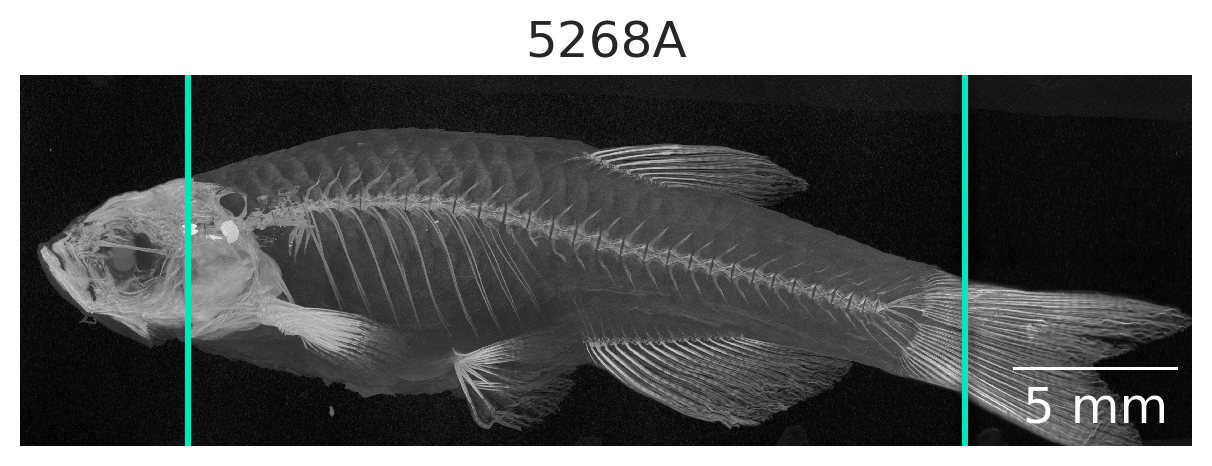

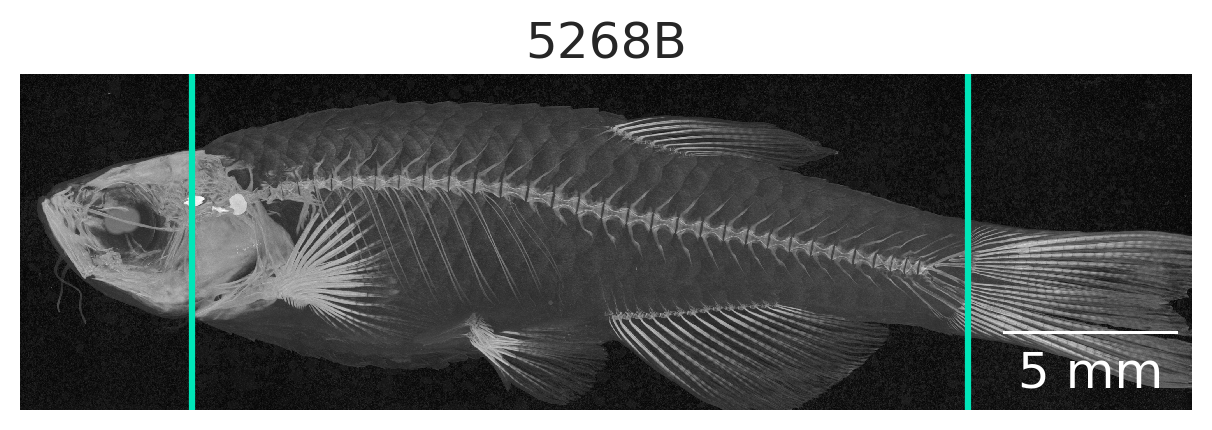

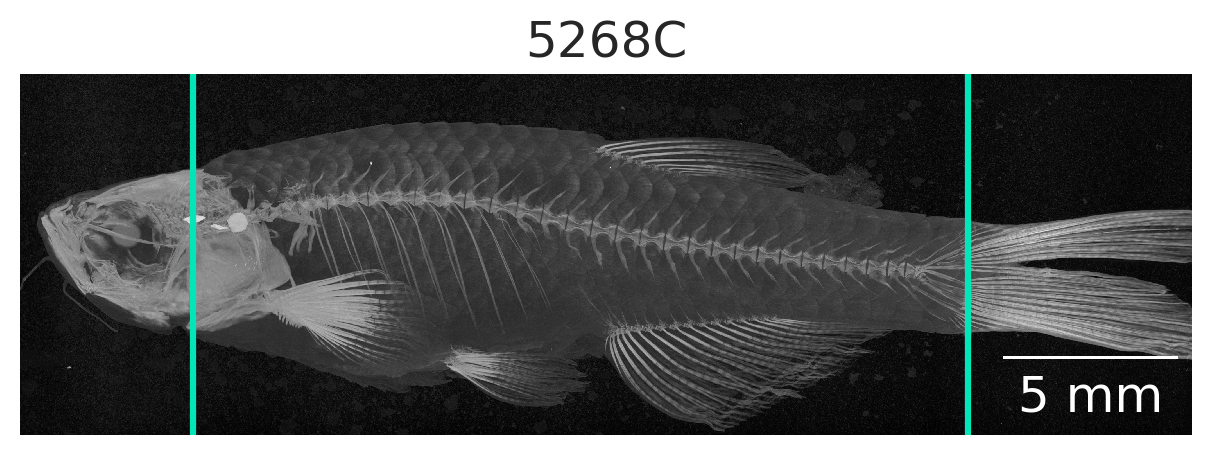

2024-01-16 10:54:26,910 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/habi/anaconda3/envs/seminar24/lib/python3.11/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/habi/anaconda3/envs/seminar24/lib/python3.11/site-packages/distributed/worker.py", line 1252, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/habi/anaconda3/envs/seminar24/lib/python3.11/site-packages/distributed/utils_comm.py", line 455, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/habi/anaconda3/envs/seminar24/lib/python3.11/site-packages

KeyboardInterrupt: 

2024-01-16 10:54:27,021 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:44543'.


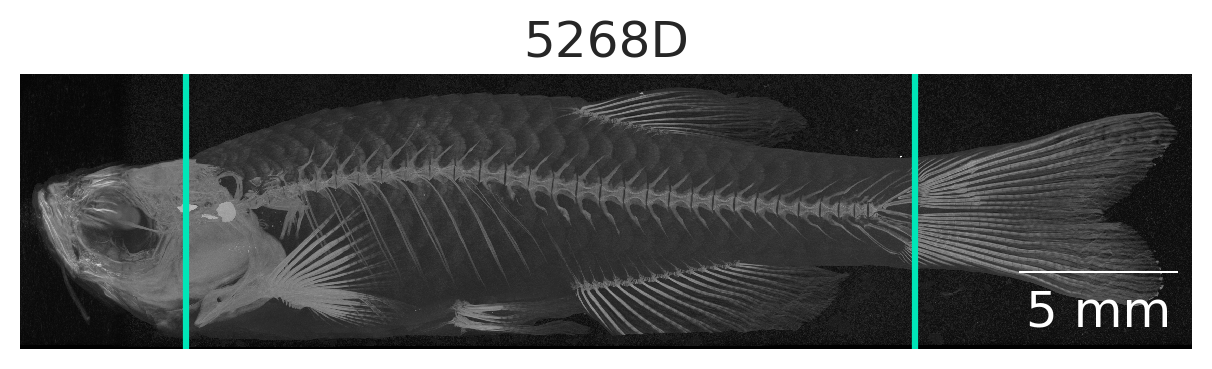

2024-01-16 10:54:28,789 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/home/habi/anaconda3/envs/seminar24/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/habi/anaconda3/envs/seminar24/lib/python3.11/asyncio/base_events.py", line 653, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/home/habi/anaconda3/envs/seminar24/lib/python3.11/site-packages/distributed/nanny.py", line 976, in run
    await worker.finished()
  File "/home/habi/anaconda3/envs/seminar24/lib/python3.11/site-packages/distributed/core.py", line 629, in finished
    await self._event_finished.wait()
  File "/home/habi/anaconda3/envs/seminar24/lib/python3.11/asyncio/locks.py", line 213, in wait
    await fut
asyncio.exceptions.CancelledError

During handling of the above excep

In [274]:
# Show the locations of the head and tail crop locations
for c, row in Data.iterrows():
    # plt.subplot(lines, int(numpy.ceil(len(Data) / lines)), c + 1)
    plt.imshow(row['MIP_Lateral'])
    plt.axvline(row.HeadCrop, c=row.Color)
    plt.axvline(row.TailCrop, c=row.Color)
    plt.title(row.Sample)
    plt.axis('off')
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    plt.tight_layout()
    plt.savefig(os.path.join(OutPutDir, 'cut.%s.png' % row.Sample), bbox_inches='tight')
    plt.show()

In [275]:
# Actually crop the reconstructions down
ReconstructionsCrop = [rec[headcrop:tailcrop] for rec, headcrop, tailcrop in zip(Reconstructions,
                                                                                 Data['HeadCrop'],
                                                                                 Data['TailCrop'])]

In [276]:
# # Show some slices laterally along the fishes
# for c, rec in enumerate(ReconstructionsCrop):
#     for k, i in enumerate(range(50, rec.shape[1], 100)):
#         plt.subplot(1, len(range(50, rec.shape[1], 100)), k + 1)
#         plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))
#         plt.imshow(rec[:,i,:], vmax=150)
#         plt.axis('off')
#     #     plt.title('%s: slice %s' % (Data['Sample'][c], i))
#     plt.show()

In [277]:
# # Show some slices laterally along the fishes
# for c, rec in enumerate(ReconstructionsCrop):
#     for k, i in enumerate(range(50, rec.shape[1], 100)):
#         plt.subplot(1, len(range(50, rec.shape[1], 100)), k + 1)
#         plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))
#         plt.imshow(rec[:,i,:], vmax=150)
#         plt.axis('off')
#         plt.title('%s: slice %s' % (Data['Sample'][c], i))
#     plt.show()

In [278]:
# Recalculate the size of the datasets
Data['SizeCrop'] = [rec.shape for rec in ReconstructionsCrop]

In [279]:
# Read or calculate the cropped middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_Crop_' + direction] = ''
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.Crop.Center.%s.png' % (row['Sample'], row['RecFolder'], direction))
    if os.path.exists(outfilepath):
        Data.at[c, 'Mid_Crop_' + direction] = imageio.imread(outfilepath)
    else:
        # Generate requested axial view
        if 'Anteroposterior' in direction:
            Data.at[c, 'Mid_Crop_' + direction] = ReconstructionsCrop[c][Data['SizeCrop'][c][0] // 2]
        if 'Lateral' in direction:
            Data.at[c, 'Mid_Crop_' + direction] = ReconstructionsCrop[c][:, Data['SizeCrop'][c][1] // 2, :]
        if 'Dorsoventral' in direction:
            Data.at[c, 'Mid_Crop_' + direction] = ReconstructionsCrop[c][:, :, Data['SizeCrop'][c][2] // 2]
        # Save the calculated 'direction' view to disk
        imageio.imwrite(outfilepath, (Data.at[c, 'Mid_Crop_' + direction]))

/tmp/ipykernel_22997/3753687205.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  Data.at[c, 'Mid_Crop_' + direction] = imageio.imread(outfilepath)


In [280]:
# Read or calculate the cropped directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_Crop_' + direction] = ''
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        outfilepath = os.path.join(os.path.dirname(row['Folder']), '%s.%s.Crop.MIP.%s.png' % (row['Sample'], row['RecFolder'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_Crop_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c, 'MIP_Crop_' + direction] = ReconstructionsCrop[c].max(axis=-d)
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_Crop_' + direction].astype('uint8'))

/tmp/ipykernel_22997/727013892.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  Data.at[c, 'MIP_Crop_' + direction] = imageio.imread(outfilepath)


In [281]:
# # Show MIP slices
# for c, row in Data.iterrows():
#     outfilepath = os.path.join(os.path.dirname(row['Folder']), row['Sample'] + '.%s.Crop.MIPs.png' % os.path.basename(row['Folder']))
#     if not os.path.exists(outfilepath):
#         for d, direction in enumerate(directions):
#             plt.subplot(1, 3, d + 1)
#             # Push contrast for display
#             plt.imshow(skimage.exposure.equalize_adapthist(row['MIP_Crop_' + direction].squeeze()))            
#             plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#             plt.title('%s\n%s' % (os.path.join(row['Sample'], row['RecFolder']),
#                                   direction + ' MIP'))
#             plt.axis('off')
#         plt.savefig(outfilepath, bbox_inches='tight')
#         plt.show()

In [282]:
# # Calculate the histograms of all (cropped) reconstructions
# # Caveat dask.da.histogram returns histogram AND bins, making each histogram a 'nested' list of [h, b]
# Data['Histogram'] = [dask.array.histogram(rec, bins=2**8, range=[0, 2**8]) for rec in ReconstructionsCrop]
# # Calculate histogram data and put only h into the dataframe, since we use it quite often below.
# # Discard the bins
# Data['Histogram'] = [h.compute() for h, b in Data['Histogram']]

In [283]:
Data['Histogram']

0    [1236845152, 389745146, 312536195, 221455523, ...
1    [982244164, 281676056, 226322361, 163089866, 1...
2    [1068290260, 304119364, 257423938, 194642603, ...
3    [732585180, 204989370, 188601315, 157037720, 1...
4    [1025564475, 291813577, 250382341, 192886274, ...
5    [724848614, 257693837, 221124694, 167563787, 1...
6    [1148595862, 331014341, 267925086, 193536527, ...
7    [1215860260, 370918055, 302520609, 215294139, ...
8    [961632522, 286141617, 242182432, 183160936, 1...
9    [933342782, 265223170, 219306910, 166366051, 1...
Name: Histogram, dtype: object

In [284]:
def legend_without_duplicate_labels(ax):
    '''https://stackoverflow.com/a/56253636/323100'''
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

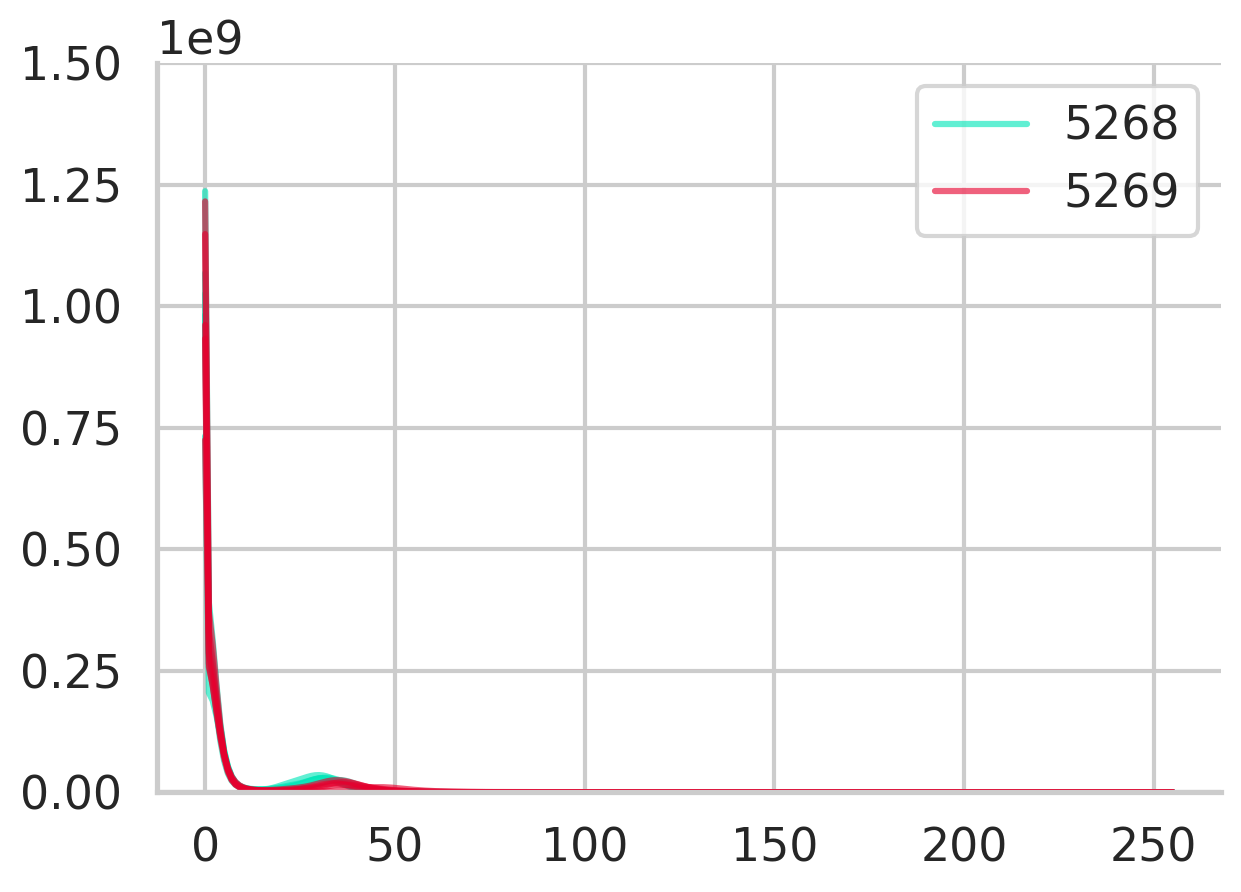

In [337]:
for c, row in Data.iterrows():
    plt.plot(row.Histogram, c=row.Color, alpha=.618, label=row.Experiment)
legend_without_duplicate_labels(plt.gca())
plt.ylim([0,1.5e9])
seaborn.despine()
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir, 'grayvaluehistogram.png'), bbox_inches='tight')

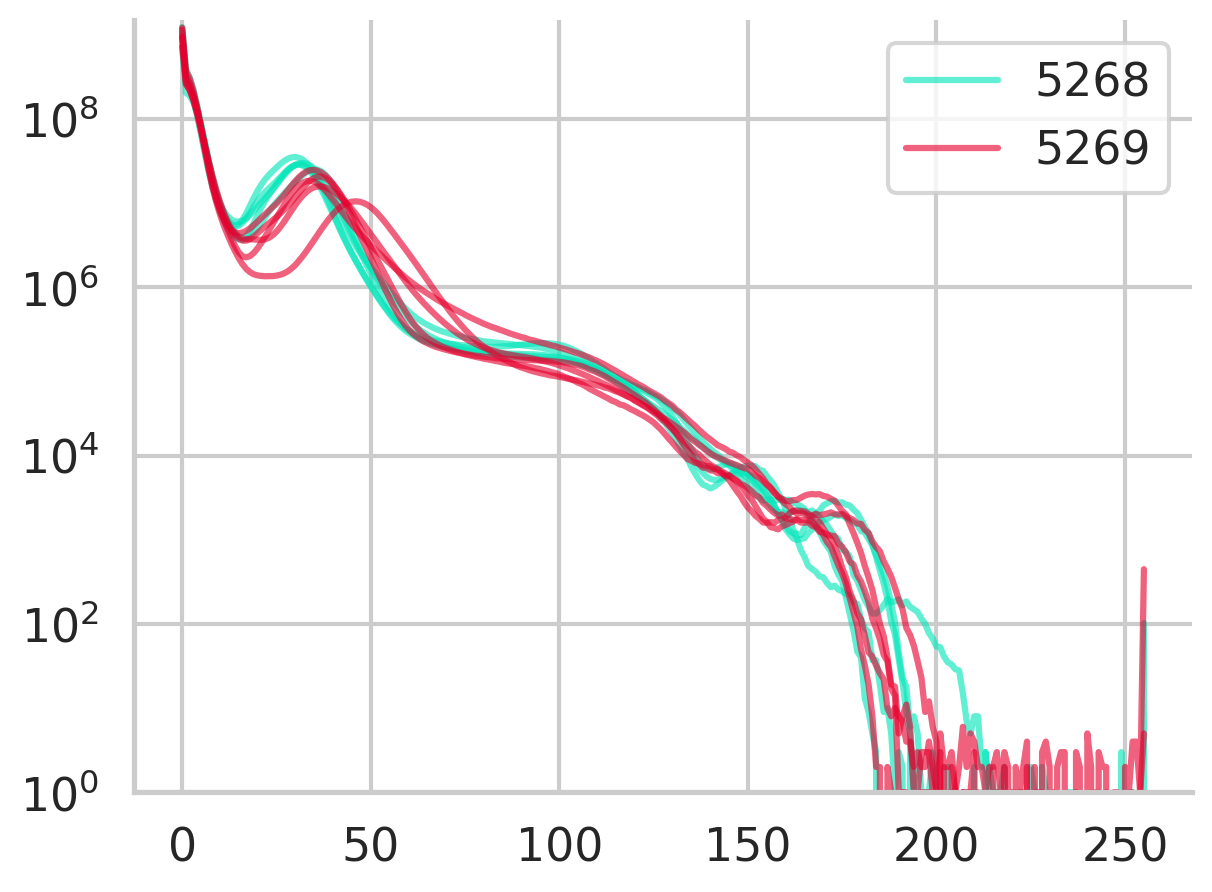

In [338]:
for c, row in Data.iterrows():
    plt.semilogy(row.Histogram, c=row.Color, alpha=.618, label=row.Experiment)
legend_without_duplicate_labels(plt.gca())
plt.ylim([1,1.5e9])
seaborn.despine()
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir, 'grayvaluehistogram.log.png'), bbox_inches='tight')

In [ ]:
# def histogramclustererKmeans(img, number_of_clusters = 5, verbose=False):
#     '''Calculate the k-means clusters
#     Speed things up with MiniBatchKMeans
#     https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
#     '''
#     # Setup k-means
#     kmeans_volume_subset = sklearn.cluster.MiniBatchKMeans(number_of_clusters)
#     # Cluster the histogram into the requested numer of clusters
#     # Do this on a subset of the images, to speed things up
#     ClusteredImg = kmeans_volume_subset.fit_predict(sorted(numpy.array(img).reshape(-1,1)))
#     # Reshape image
#     ClusteredImg.shape = img.shape
#     if verbose:
#         # Calculate histogram
#         histogram, bins = dask.array.histogram(img, bins=2**8, range=[0, 2**8])
#         plt.semilogy(numpy.log(histogram), label='Gray value histogram')
#         plt.semilogy(histogram, label='Gray value histogram (log)')
#         for c, cluster in enumerate(sorted(kmeans_volume_subset.cluster_centers_.squeeze())):
#             plt.axvline(cluster, label='Cluster center %s at %0.0f' % (c,  cluster),
#                         color=seaborn.color_palette(n_colors=number_of_clusters)[c])
#         plt.legend()
#         plt.xlim([0,2**8])
#         plt.title('Logarithmic histogram of input image with %s cluster centers' % number_of_clusters)
#         plt.show()
#     return(sorted(kmeans_volume_subset.cluster_centers_.squeeze()))

In [ ]:
# def histogramclustererOtsu(img, number_of_clusters = 5, verbose=False):
#     '''Use Multi-Otsu Thresholding instead of k-means clusters'''
#     # Applying multi-Otsu threshold with the selected number of classes
#     thresholds = threshold_multiotsu(img.compute(), classes=number_of_clusters)
#     if verbose:
#         # Calculate histogram
#         histogram, bins = dask.array.histogram(img, bins=2**8, range=[0, 2**8])
#         plt.semilogy(numpy.log(histogram), label='Gray value histogram')
#         plt.semilogy(histogram, label='Gray value histogram (log)')
#         for c, threshold in enumerate(thresholds):
#             plt.axvline(threshold, label='Threshold %s at %0.0f' % (c,  threshold),
#                         color=seaborn.color_palette(n_colors=number_of_clusters)[c])
#         plt.legend()
#         plt.xlim([0,2**8])
#         plt.title('Logarithmic histogram of input image with %s cluster centers' % number_of_clusters)
#         plt.show()
#     return(sorted(thresholds))

In [60]:
# Using the MultiOtsu clustering as compared to tke k-means clustering is more robust, so we prefer that

In [61]:
# subset = 5
# discardgrayvalue = 5

In [62]:
# Data['HistogramCentersKmeans'] = [histogramclustererKmeans(rec[::subset,::subset,::subset][rec[::subset,::subset,::subset] > discardgrayvalue].compute(),
#                                                           number_of_clusters=5) for rec in ReconstructionsCrop]

In [63]:
# for c, row in Data.iterrows():
#     print(row.Sample, row.HistogramCentersKmeans)

In [298]:
# Data['HistogramCentersMultiOtsu'] = [histogramclustererOtsu(rec[rec > discardgrayvalue],
#                                                             number_of_clusters=5) for rec in ReconstructionsCrop]

In [299]:
for c, row in Data.iterrows():
    print(row.Sample, row.HistogramCentersMultiOtsu)

5268A [17, 30, 42, 72]
5268B [16, 27, 37, 68]
5268C [17, 31, 42, 73]
5268D [15, 27, 37, 68]
5268E [16, 28, 38, 69]
5269A [21, 40, 53, 81]
5269B [16, 30, 41, 69]
5269C [19, 34, 49, 79]
5269D [16, 29, 39, 69]
5269E [18, 33, 45, 73]


In [66]:
# [numpy.ma.masked_less(cc, 13).compressed() for cc in Data['ClusterCenters']]
# Data['ClusterCenters'] = [numpy.ma.masked_greater(cc, 999).compressed() for cc in Data['ClusterCenters']]

In [67]:
# Data['Histogramlength'] = [len(h) for h in Data['Histogram']]

In [68]:
# seaborn.lineplot(data=Data)

In [69]:
# # All histograms, colored per experiment
# for c, row in Data.iterrows():
#     color = 0
#     if row.Experiment == '5268':
#         color = 1
#     plt.semilogy(row.Histogram,
#                  label=row.Sample,
#                  color=seaborn.color_palette(n_colors=2)[color])
# plt.xlim([0, 2**8])
# plt.legend()
# plt.savefig(os.path.join(OutPutDir, 'Histograms_Experiment.png'),  transparent=True)
# # plt.savefig(os.path.join('P:/Talks/20230904_COMULIS/images/cox7a/Histograms_Experiment.png'),  transparent=True, bbox_inches='tight')
# plt.show()

In [70]:
# iterator = 500
# for c, clustercntr in enumerate(Data['ClusterCenters']):
#     print('-----Sample %s----' % Data['Sample'][c])
#     for imgnr, image in enumerate(ReconstructionsCrop[c][::iterator]):
#         for d, threshold in enumerate(clustercntr):
#             plt.subplot(1, len(clustercntr), d + 1)
#             plt.imshow(image)
#             plt.imshow(image<threshold, cmap='viridis', alpha=0.5)
#             plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))
#             plt.title('%s\nThreshold %s' % (os.path.basename(row.Reconstructions[row.HeadCrop:row.TailCrop][::iterator][imgnr]),
#                                             round(threshold, 2)))
#             plt.axis('off')
#         plt.show()

In [71]:
# # Apply a median filter to the cropped reconstructions
# mediansize = 3
# ReconstructionsMedian = [dask_image.ndfilters.median_filter(rec, size=mediansize) for rec in ReconstructionsCrop]

In [72]:
# whichsample = 2
# step = 600

In [73]:
# imagenumber = range(800,len(ReconstructionsCrop[whichsample]-1000),step)
# for i, threshold in enumerate(Data['HistogramCentersMultiOtsu'][whichsample]):
#     print(threshold)
#     for c, imgnmb in enumerate(imagenumber):
#         plt.subplot(lines, int(numpy.ceil(len(imagenumber) / float(lines))), c + 1)
#         plt.imshow(ReconstructionsCrop[whichsample][imgnmb]>threshold)
#         plt.title('%s>%s' % (imgnmb, threshold))
#         plt.axis('off')
#     plt.show()

In [300]:
# Save out thresholded fish
Data['OutputNameThresholded'] = [on.replace('.zarr', '.thresholded_%02d.zarr' % threshold[0]) for on,threshold in zip(Data['OutputNameRec'],
                                                                                                                      Data['HistogramCentersMultiOtsu'])]
for c, row in Data.iterrows():
    if not os.path.exists(row['OutputNameThresholded']):
        (ReconstructionsCrop[c]>row['HistogramCentersMultiOtsu'][0]).rechunk(chunks='auto').to_zarr(row['OutputNameThresholded']) 

In [301]:
# Load thresholded reconstructions back in
ReconstructionsThresholded = [dask.array.from_zarr(file) for file in Data['OutputNameThresholded']]

In [76]:
# # Write out largest component as png slices
# # Prepare foldername first
# # Now calculate the segmentation and write them out
# for c, row in Data.iterrows():
#     # Generate output folder
#     outputdir = row.OutputNameThresholded.replace('.zarr', '')
#     # print(outputdir)
#     os.makedirs(outputdir, exist_ok=True)
#     for d, name in enumerate(row.Reconstructions[row.HeadCrop:row.TailCrop]):
#         filename = os.path.join(outputdir,
#                                 os.path.basename(name).replace('.png', '_thresholded%02d.png' % row.HistogramCentersMultiOtsu[0]))
#         if not os.path.exists(filename):
#             # print(filename)
#             imageio.imwrite(filename, ReconstructionsThresholded[c][d].astype('uint8') * 2**8)

In [77]:
# def getLargestCC(segmentation):
#     # https://stackoverflow.com/a/55110923/323100 adapted to dask
#     labels, numfeatures = dask_image.ndmeasure.label(segmentation)
#     labels.compute_chunk_sizes() 
#     # labels.compute()
#     # assert( labels.max() != 0 ) # assume at least 1 CC
#     largestCC = labels == dask.array.argmax(dask.array.bincount(dask.array.ravel(labels))[1:])+1
#     return largestCC

In [302]:
def getLargestCC(segmentation):
    labels = skimage.measure.label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == numpy.argmax(numpy.bincount(labels.flat)[1:]) + 1
    return largestCC

In [303]:
# Save out largest component of thresholded fish
# Save out as NUMPY file, because we couldn't get dask to work properly...
Data['OutputNameLargestCC'] = [on.replace('.zarr', '.largestCC.npy') for on in Data['OutputNameThresholded']]
for c, row in Data.iterrows():
    if not os.path.exists(row['OutputNameLargestCC']):
        numpy.save(row['OutputNameLargestCC'], getLargestCC(ReconstructionsThresholded[c]))

In [304]:
# Load thresholded reconstructions back in
ReconstructionsLargestCC = [numpy.load(file) for file in Data['OutputNameLargestCC']]

In [81]:
#for file in Data['OutputNameLargestCC']:
#    # https://stackoverflow.com/a/72666271/323100
#    print(file.replace('.npy','.zarr'))
#    arr = numpy.load(file, mmap_mode='r')
#    da = dask.array.from_array(arr).rechunk(chunks='auto')
#    da.to_zarr(file.replace('.npy','.zarr'),
#               overwrite=True,
#               compressor=Blosc(cname='zstd',
#                                shuffle=Blosc.BITSHUFFLE))

In [82]:
# for whichsample in range(len(Data)):
#     whichslice=500
#     plt.subplot(131)
#     plt.imshow(ReconstructionsCrop[whichsample][whichslice])
#     plt.title('%s, original' % Data.Sample[whichsample])
#     plt.axis('off')
#     plt.subplot(132)
#     plt.imshow(ReconstructionsThresholded[whichsample][whichslice])
#     plt.title('thresholded with %s' % Data['HistogramCentersMultiOtsu'][whichsample][0])
#     plt.axis('off')
#     plt.subplot(133)
#     plt.imshow(ReconstructionsLargestCC[whichsample][whichslice])
#     plt.title('slice %s, largest CC' % whichslice)
#     plt.axis('off')
#     plt.show()

In [83]:
#Data['ClusterCentersMedian'] =[histogramclustererKmeans(rec[::subset,::subset,::subset][rec[::subset,::subset,::subset] > discardgrayvalue]) for rec in ReconstructionsMedian]

In [84]:
#for c, row in Data.iterrows():
#    print(row.Sample, row.ClusterCentersMedian)

In [85]:
# Data['ClusterCentersMedian'] = [numpy.ma.masked_less_equal(ccm, 15).compressed() for ccm in Data['ClusterCentersMedian']]
# Data['ClusterCentersMedian'] = [numpy.ma.masked_greater(ccm, 60).compressed() for ccm in Data['ClusterCentersMedian']]

In [86]:
# for c, row in Data.iterrows():
#     print(row.Sample, row.ClusterCentersMedian)

In [87]:
# Histograms of median data per experiment
#for c, experiment in enumerate(Data.Experiment.unique()):
#    plt.subplot(2, 1, c + 1)
#    plt.title(experiment)
#    for c, row in Data[Data.Experiment == experiment].iterrows():
#        plt.semilogy(row.HistogramMedian,
#                     label=row.Sample,
#                     color=seaborn.color_palette(n_colors=len(Data))[c])
#        for cc in row.ClusterCentersMedian:
#            plt.axvline(cc,
#                        color=seaborn.color_palette(n_colors=len(Data))[c],
#                        alpha=.616)
#    plt.xlim([0, 2**6])
#    plt.legend()
#plt.savefig(os.path.join(OutPutDir, 'Histograms.Median.Experiment.ClusterCenters.png'))
#plt.show()

In [88]:
# # All median histograms, colored per experiment
#for c, row in Data.iterrows():
#    color = 0
#    if row.Experiment == 'WT':
#        color = 1
#    plt.semilogy(row.HistogramMedian,
#                 label=row.Sample,
#                 color=seaborn.color_palette(n_colors=2)[color])
#plt.xlim([0, 2**8])
#plt.legend()
#plt.savefig(os.path.join(OutPutDir, 'Histograms.Median.Experiment.png'), transparent=True)
#plt.show(#)

In [89]:
print(OutPutDir)

../media/cox7a


In [90]:
# # Calculate peaks of all histograms, we use them for the segmentation afterwards
# # If we would use '-h', we can calculate the (first) valley of the histogram, which mostly conforms to the first peak of the MultiOtsu
# Data['Peaks'] = [scipy.signal.find_peaks(h) for h in Data['Histogram']]
# # Mask out background and large gray values
# Data['Peaks'] = [dask.array.ma.masked_outside(p, 1, 80).compute().compressed() for p, details in Data['Peaks']]

In [91]:
# Data['Peaks']

In [92]:
# # Histograms per experiment
# for c, row in Data.iterrows():
#     plt.subplot(131)
#     plt.semilogy(row.Histogram, c=row.Color)
#     for d, center in enumerate(row.HistogramCentersMultiOtsu):
#         if not d:
#             plt.axvline(center, c='black', label=round(center))
#         else:
#             plt.axvline(center, c=row.Color, label=round(center))
#     plt.title('MultiOtsu %s' % row.Sample)
#     plt.xlim([0,2**8])
#     plt.legend()
#     plt.subplot(132)
#     plt.semilogy(row.Histogram, c=row.Color)
#     for center in row.HistogramCentersKmeans:
#         plt.axvline(center, c=row.Color, label=round(center))
#     plt.title('KMeans %s' % row.Sample)
#     plt.xlim([0,2**8])
#     plt.legend()
#     plt.subplot(133)
#     plt.semilogy(row.Histogram, c=row.Color)
#     for center in row.Peaks:
#         plt.axvline(center, c=row.Color, label=round(center))
#     plt.title('Peaks %s' % row.Sample)
#     plt.xlim([0,2**8])
#     plt.legend()
#     outputname = os.path.join(os.path.dirname(row.Folder), '%s.%s.Histograms.png' % (row.Sample, row.RecFolder))
#     if not os.path.exists(outputname):
#         plt.savefig(outputname)
#     plt.show()

In [93]:
# for c, row in Data.iterrows():
#     plt.semilogy(row.Histogram, c=row.Color, alpha=.618, label=row.Experiment)
#     plt.axvline(row.HistogramCentersMultiOtsu[0], c=row.Color, alpha=.618)
# legend_without_duplicate_labels(plt.gca())
# seaborn.despine()
# plt.tight_layout()
# # plt.savefig(os.path.join(OutPutDir, 'grayvaluehistogram.log.png'))

In [94]:
# Data['Volume'] = [dask.array.count_nonzero(rec > threshold[0]).compute() for rec, threshold in zip(ReconstructionsCrop,
#                                                                                                    Data.HistogramCentersMultiOtsu)]

In [306]:
Data[['Experiment', 'Color', 'Volume', 'VolumelCC']]

,Experiment,Color,Volume,VolumelCC
0,5268,#00E6B8,470783246,465478015
1,5268,#00E6B8,461341737,448489086
2,5268,#00E6B8,420332986,411504488
3,5268,#00E6B8,579664918,567698555
4,5268,#00E6B8,507018963,491885279
5,5269,#E6002E,223204427,218567576
6,5269,#E6002E,370617892,360581076
7,5269,#E6002E,340054992,337681057
8,5269,#E6002E,442695846,429602363
9,5269,#E6002E,322983520,308415695


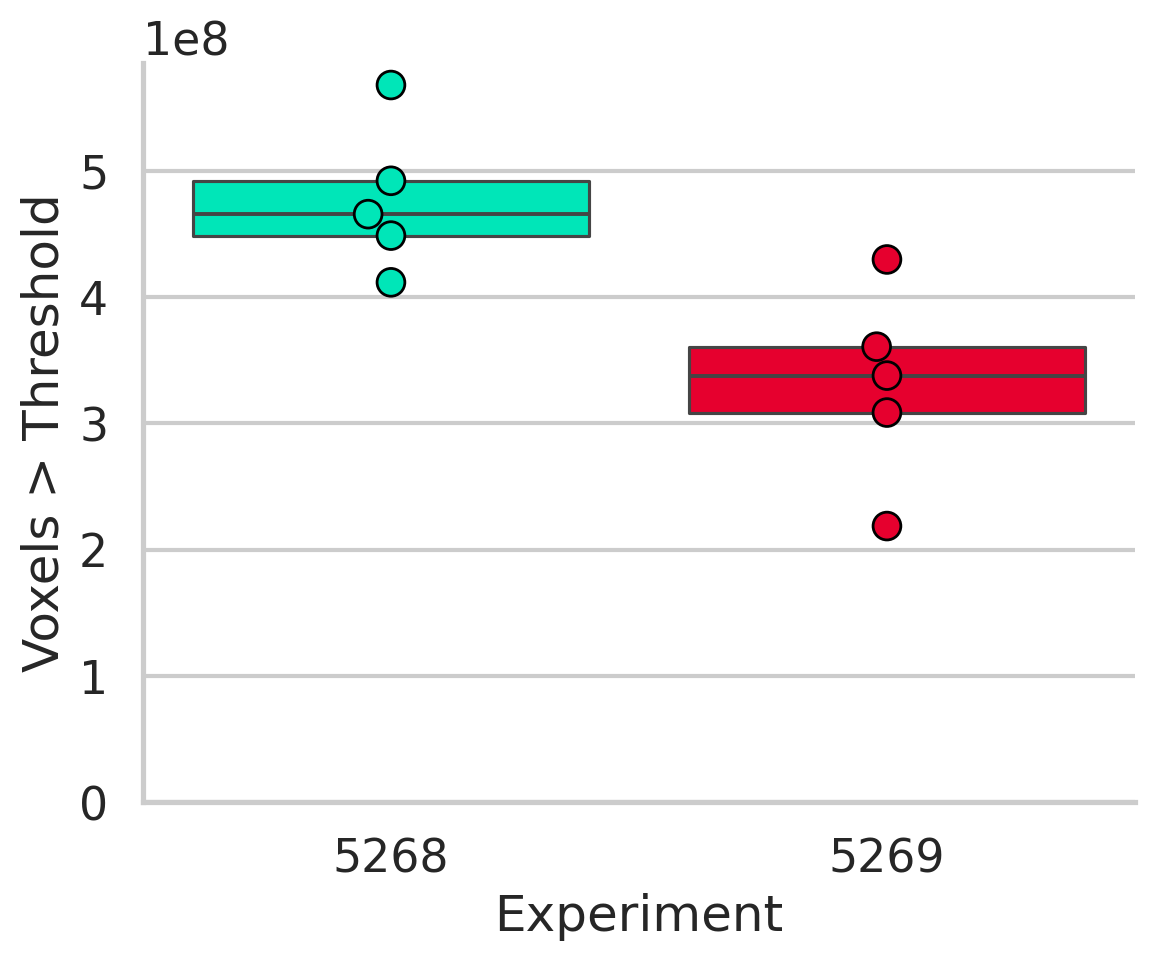

In [339]:
seaborn.boxenplot(data=Data,
                  x='Experiment',
                  y='VolumelCC',
                  hue='Experiment',
                  width=0.8,
                  #https://stackoverflow.com/questions/68297642/how-to-choose-seaborn-boxplots-color-by-hue#comment120707639_68297642                
                  palette={"5268": "#00E6B8", "5269": "#E6002E"},
                  saturation=1)
seaborn.swarmplot(data=Data,
                  x='Experiment',
                  y='VolumelCC',
                  hue='Experiment',
                  palette={"5268": "#00E6B8", "5269": "#E6002E"},                  
                  s=10,
                  edgecolor='black',
                  linewidth=1,
                  # jitter=0.8/2,
                  # alpha=0.618
                 )
plt.ylim(ymin=0)
plt.ylabel('Voxels > Threshold')
seaborn.despine()
plt.savefig(os.path.join(OutPutDir, 'Volume_Boxplot.5268_5269.ThresholdedVolumeLargestComponent.png'), bbox_inches='tight')
plt.show()

In [ ]:
# Data['VolumelCC'] = [numpy.count_nonzero(rlCC) for rlCC in ReconstructionsLargestCC]

In [318]:
Data[['Sample', 'HistogramCentersMultiOtsu', 'Volume', 'VolumelCC']]

,Sample,HistogramCentersMultiOtsu,Volume,VolumelCC
0,5268A,"[17, 30, 42, 72]",470783246,465478015
1,5268B,"[16, 27, 37, 68]",461341737,448489086
2,5268C,"[17, 31, 42, 73]",420332986,411504488
3,5268D,"[15, 27, 37, 68]",579664918,567698555
4,5268E,"[16, 28, 38, 69]",507018963,491885279
5,5269A,"[21, 40, 53, 81]",223204427,218567576
6,5269B,"[16, 30, 41, 69]",370617892,360581076
7,5269C,"[19, 34, 49, 79]",340054992,337681057
8,5269D,"[16, 29, 39, 69]",442695846,429602363
9,5269E,"[18, 33, 45, 73]",322983520,308415695


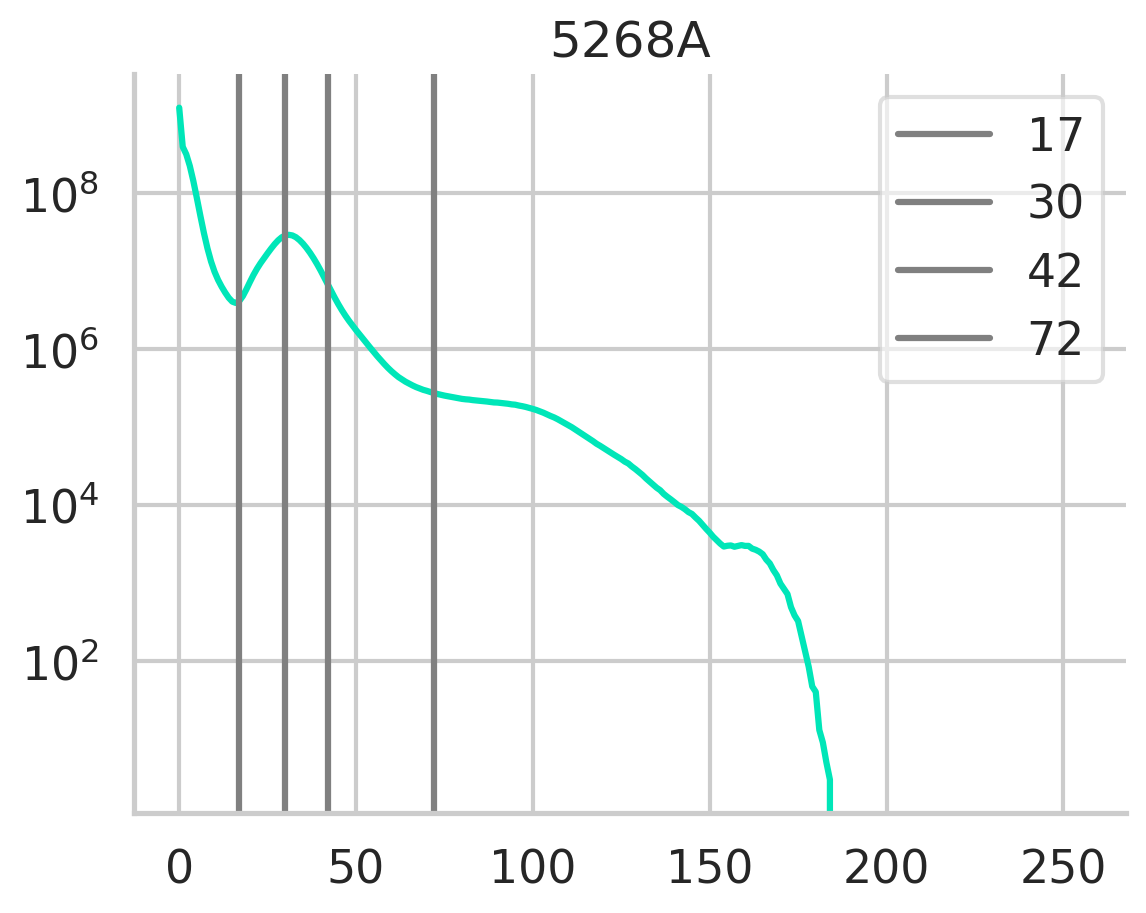

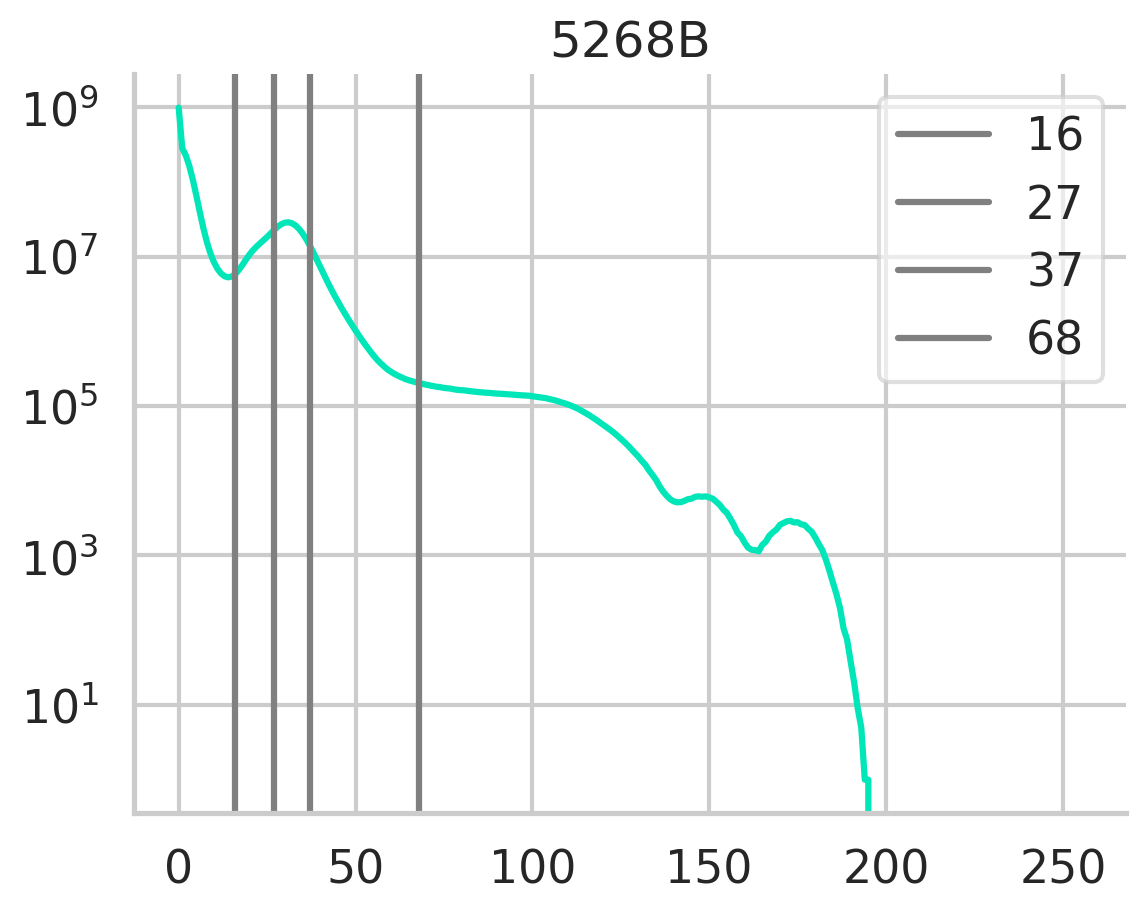

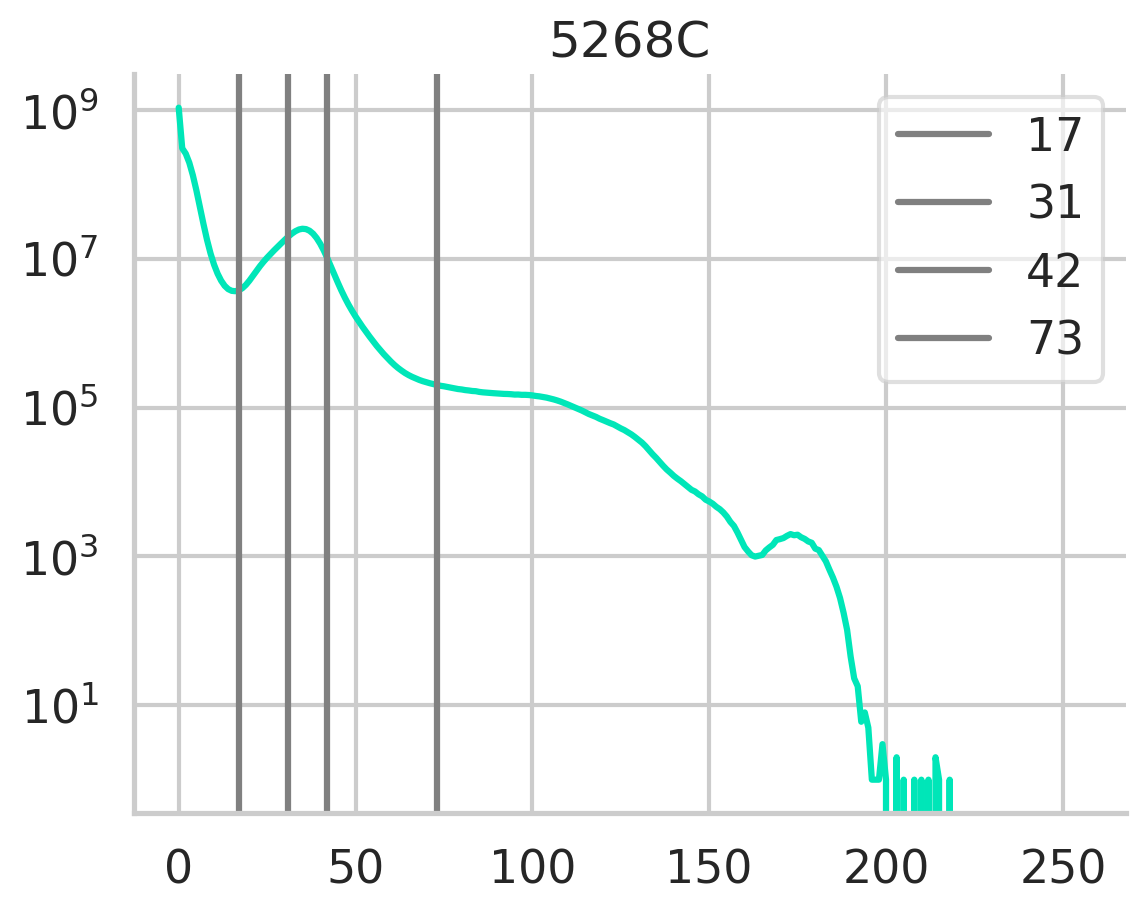

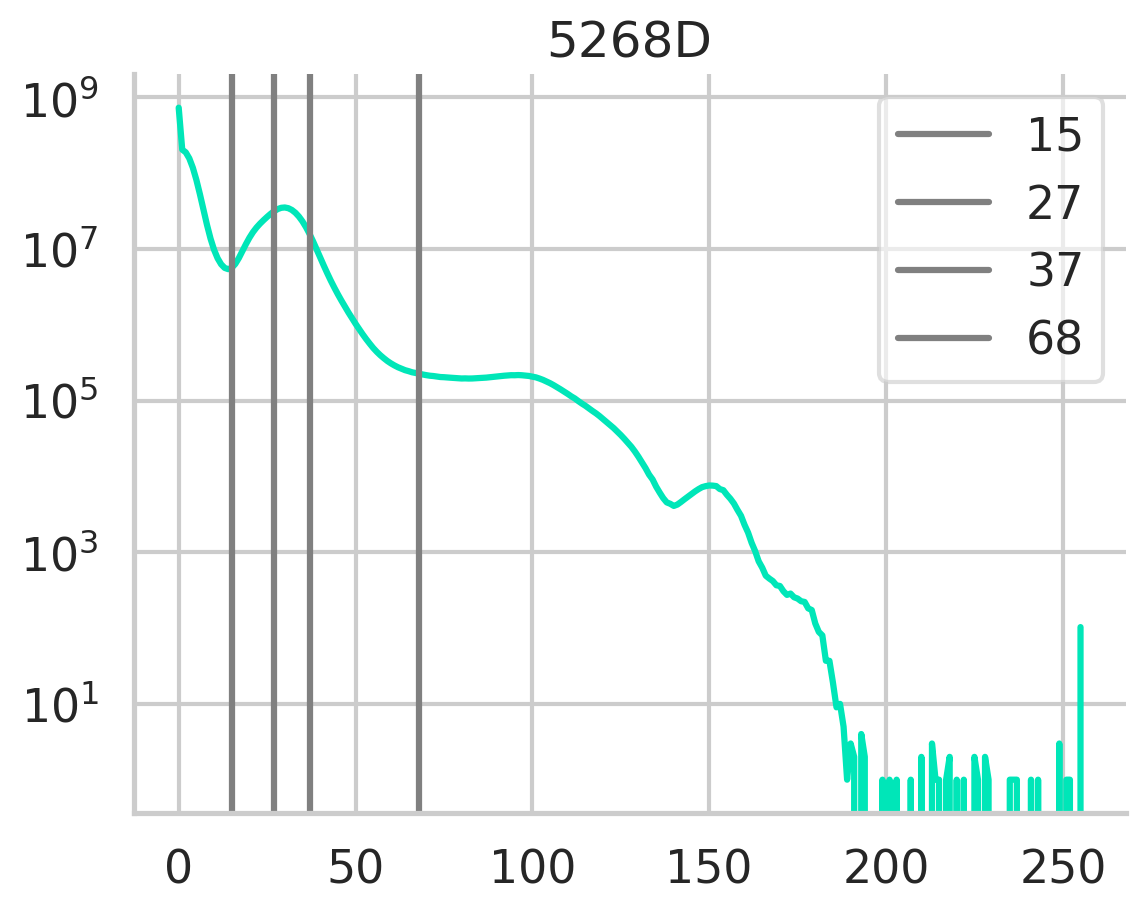

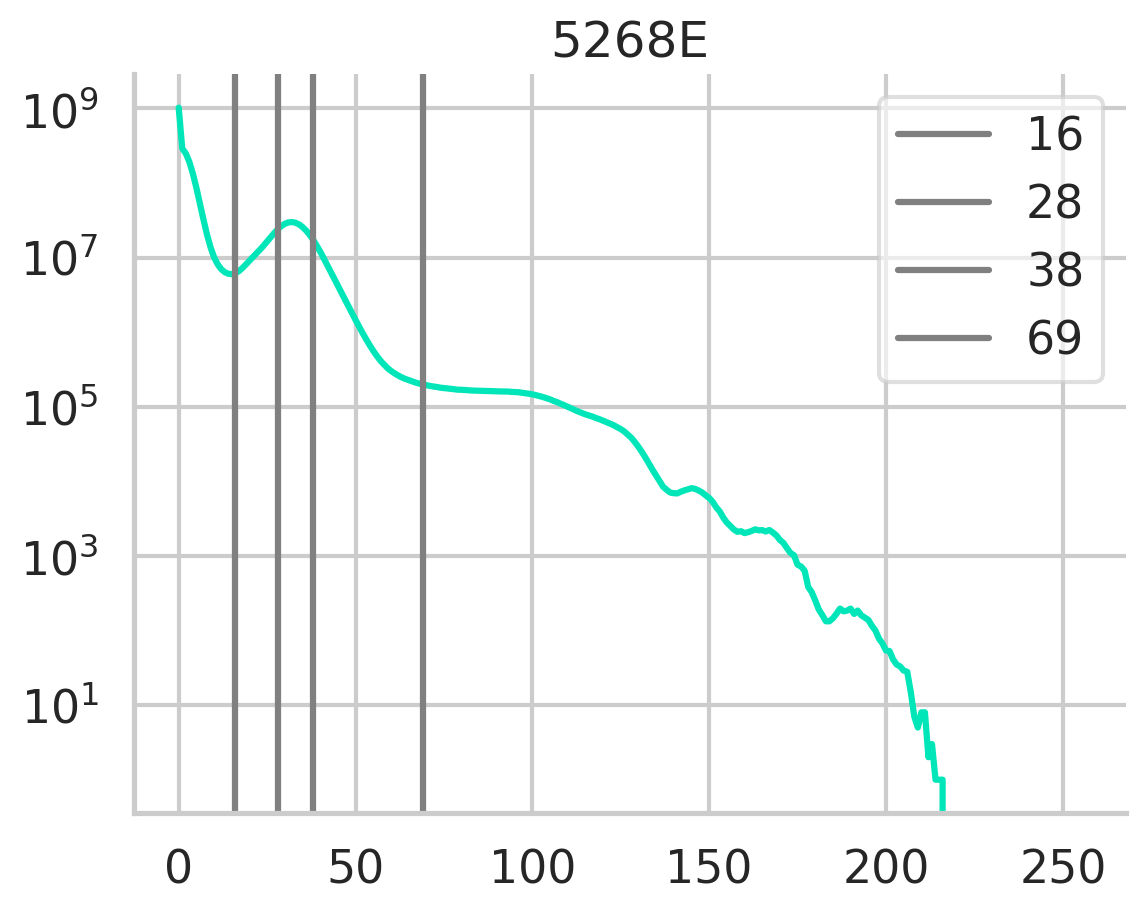

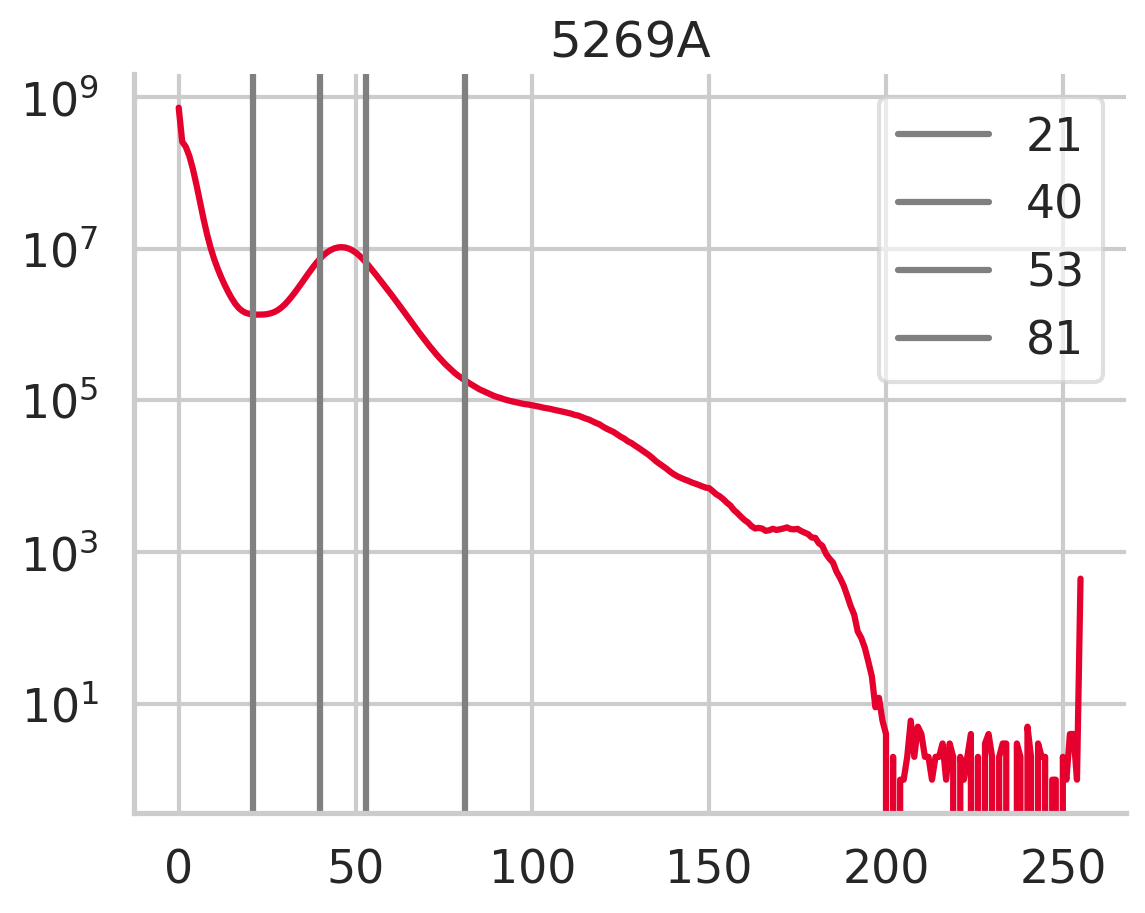

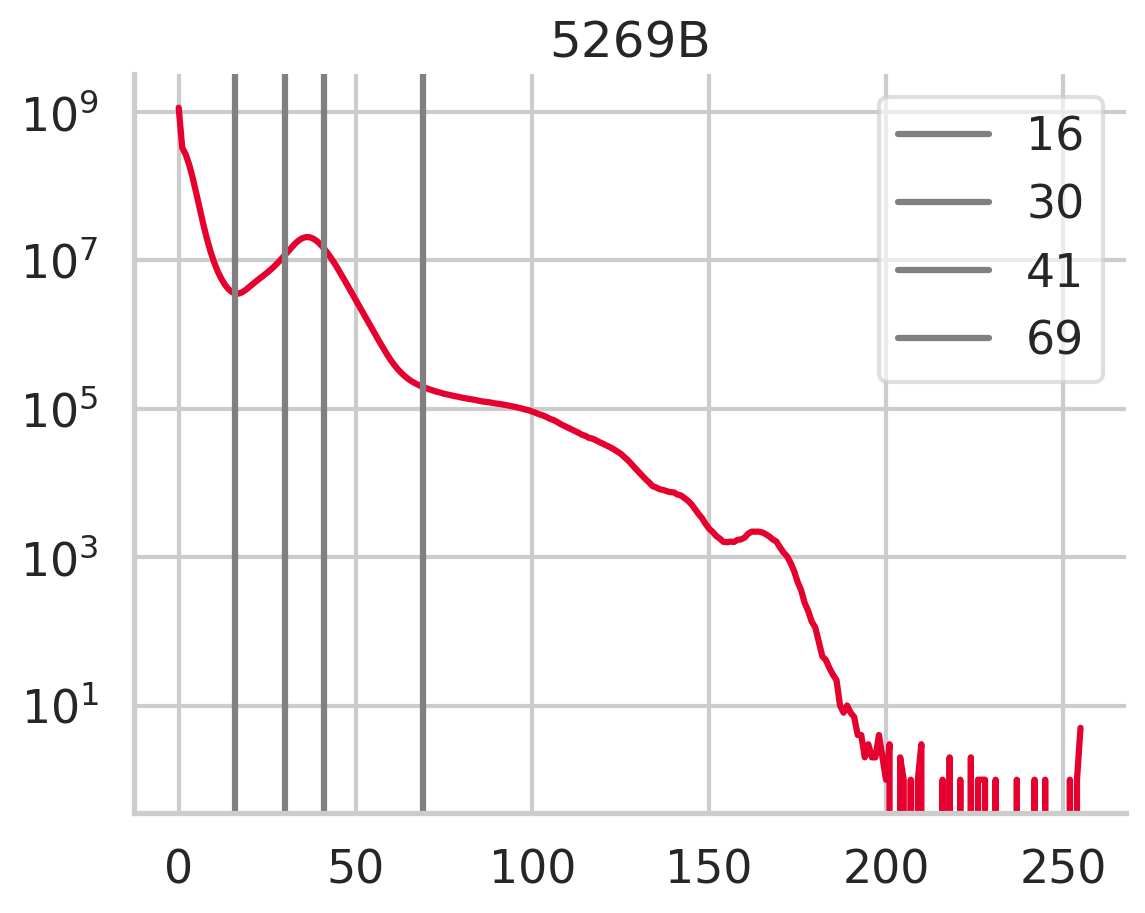

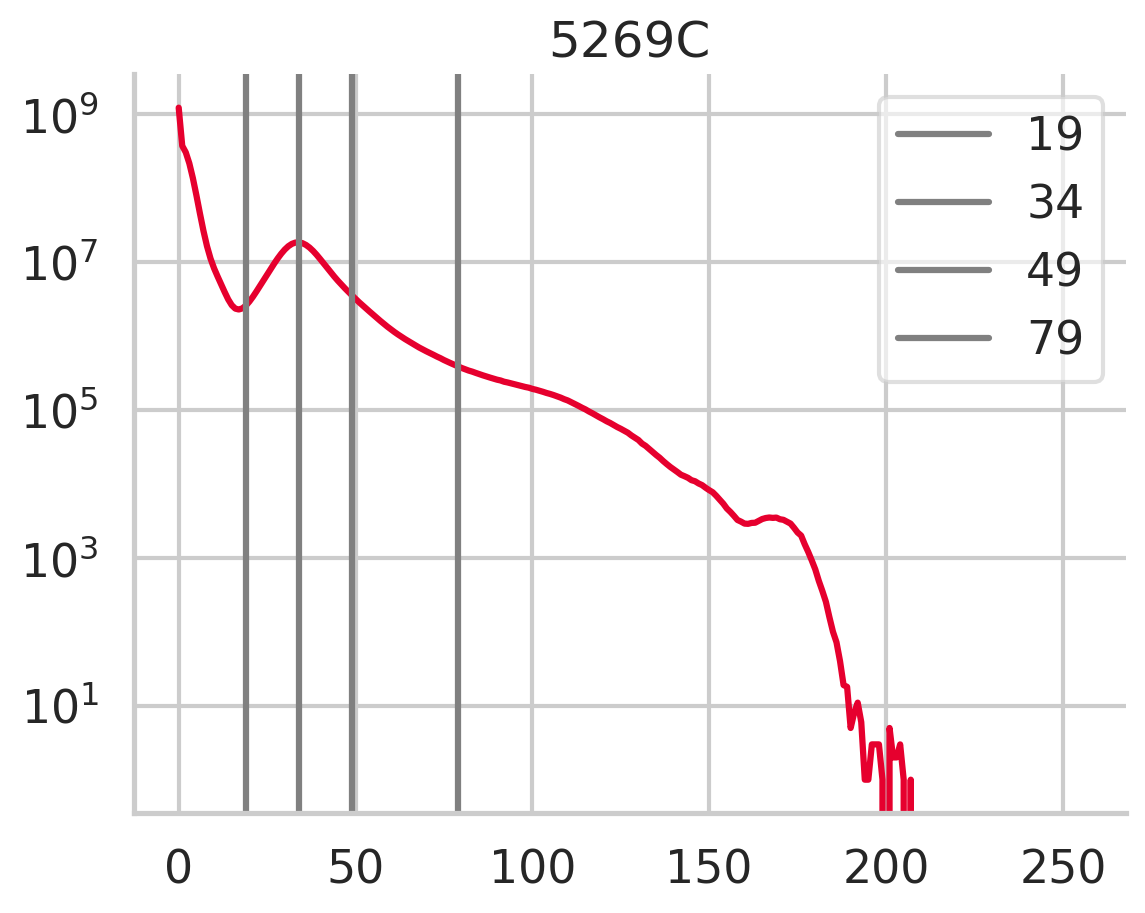

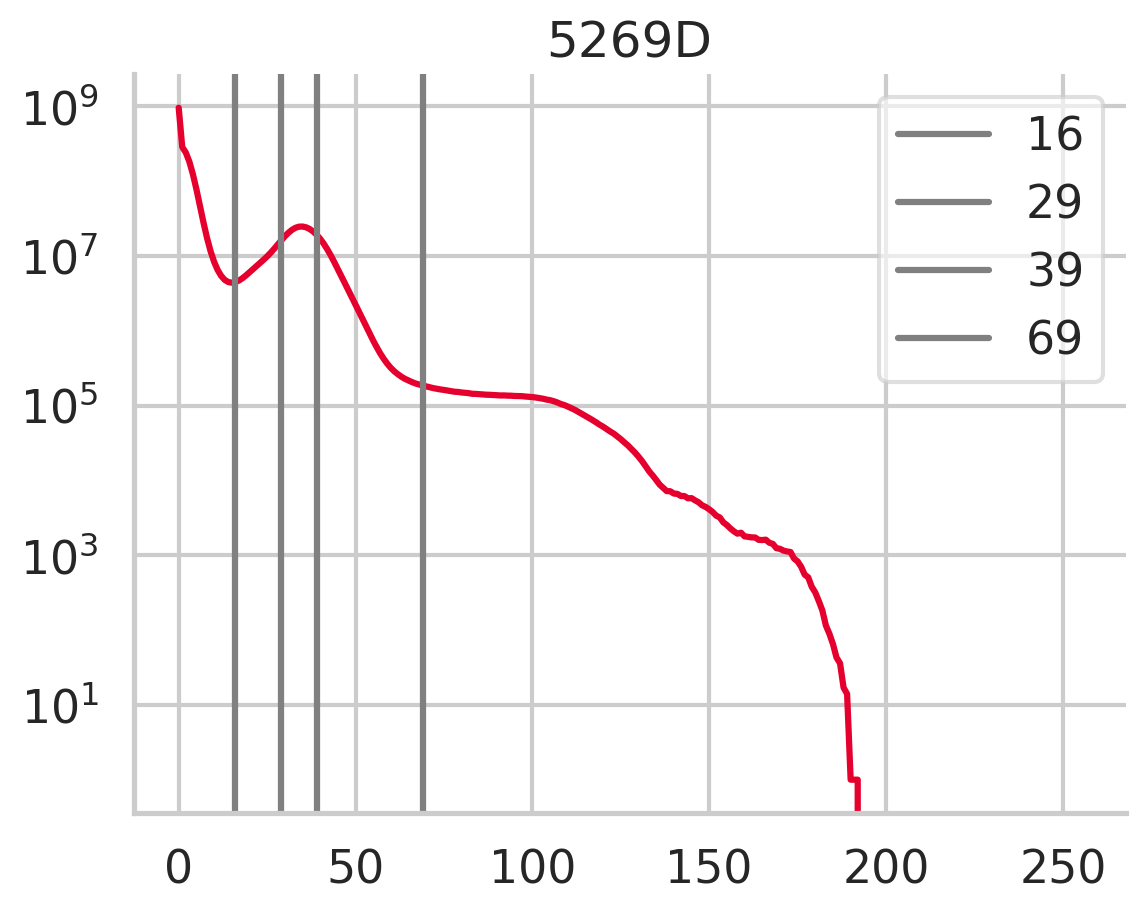

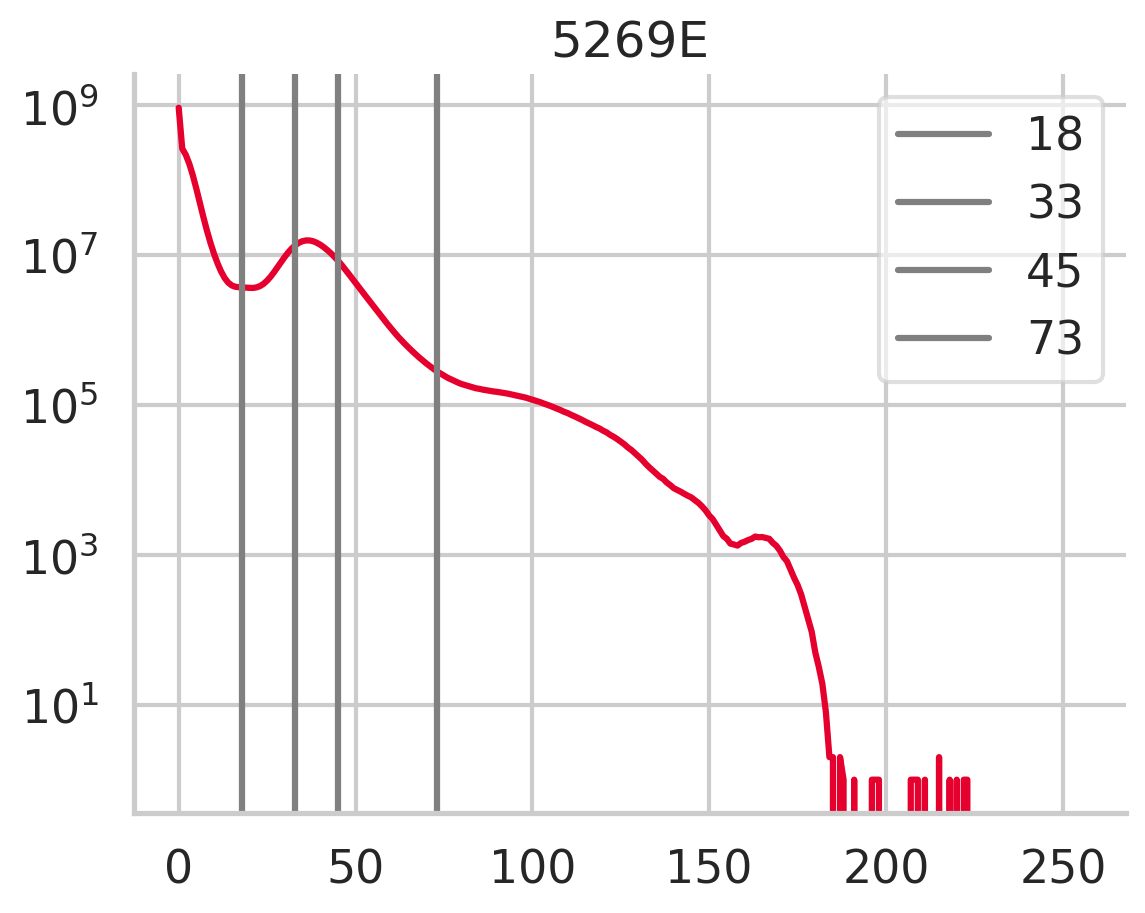

In [340]:
for c, row in Data.iterrows():
    plt.semilogy(row.Histogram, c=row.Color)
    for d,threshold in enumerate(row.HistogramCentersMultiOtsu):
        plt.axvline(threshold, c='gray', label=threshold)
    plt.legend(facecolor='white', framealpha=0.618)
    plt.title(row.Sample)
    seaborn.despine()
    plt.savefig(os.path.join(OutPutDir, 'histogram.%s.png' % row.Sample), bbox_inches='tight')
    plt.show()

In [333]:
Data[['Volume', 'VolumelCC', 'SegmentedVolume_mm']]

,Volume,VolumelCC,SegmentedVolume_mm
0,470783246,465478015,238.320275
1,461341737,448489086,229.622107
2,420332986,411504488,210.686347
3,579664918,567698555,290.656210
4,507018963,491885279,251.840541
5,223204427,218567576,111.904501
6,370617892,360581076,184.614049
7,340054992,337681057,172.889459
8,442695846,429602363,219.952286
9,322983520,308415695,157.905875


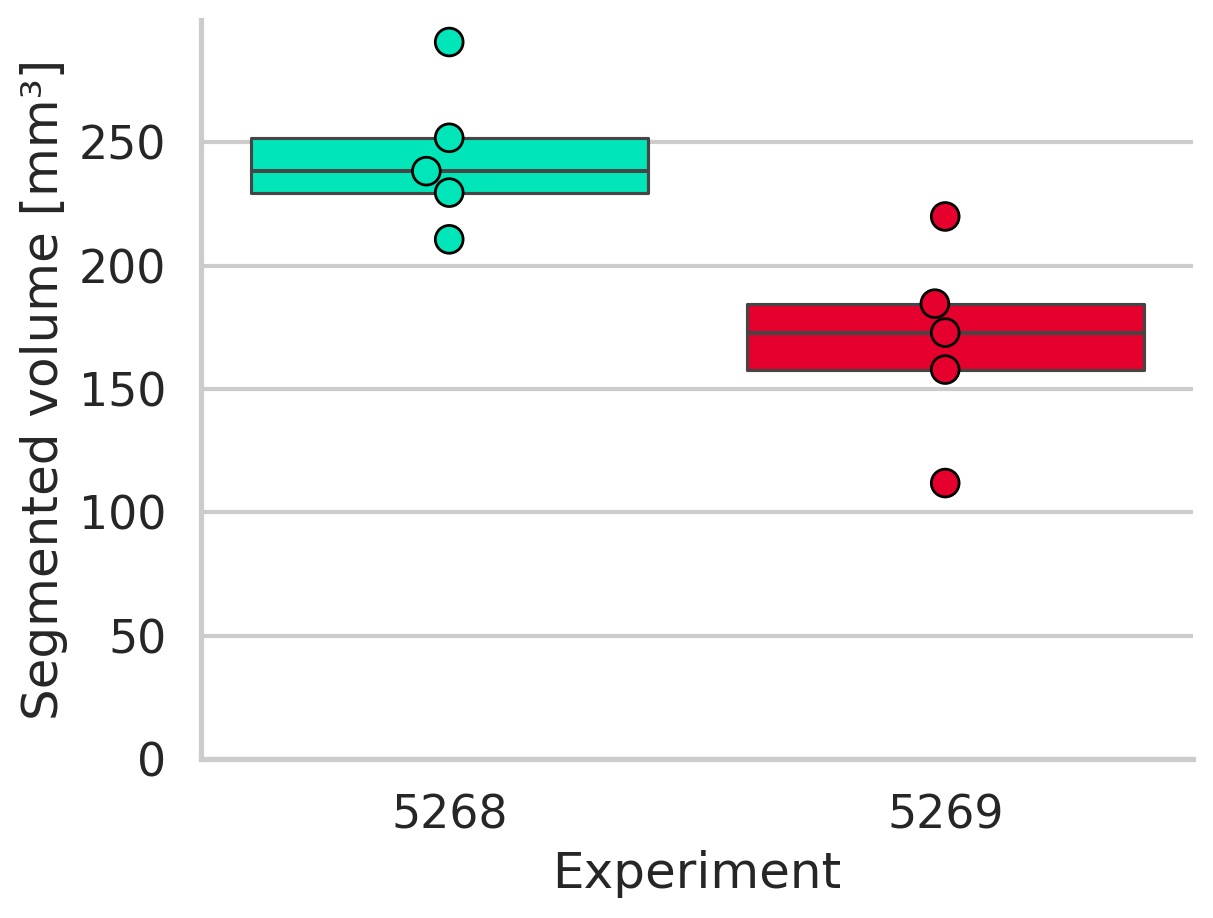

In [336]:
seaborn.boxenplot(data=Data,
                  x='Experiment',
                  y='SegmentedVolume_mm',
                  hue='Experiment',
                  width=0.8,
                  #https://stackoverflow.com/questions/68297642/how-to-choose-seaborn-boxplots-color-by-hue#comment120707639_68297642                
                  palette={"5268": "#00E6B8", "5269": "#E6002E"},
                  saturation=1)
seaborn.swarmplot(data=Data,
                  x='Experiment',
                  y='SegmentedVolume_mm',
                  hue='Experiment',
                  palette={"5268": "#00E6B8", "5269": "#E6002E"},                  
                  s=10,
                  edgecolor='black',
                  linewidth=1,
                  # jitter=0.8/2,
                  # alpha=0.618
                 )
plt.ylim(ymin=0)
plt.ylabel('Segmented volume [mm³]')
seaborn.despine()
plt.savefig(os.path.join(OutPutDir, 'Volume_Boxplot.5268_5269.SegmentedVolumemm3.png'), bbox_inches='tight')
plt.show()

In [ ]:
print(OutPutDir)

In [ ]:
# whichone = 6
# slice = 555
# plt.subplot(131)
# plt.imshow(ReconstructionsCrop[whichone][slice])
# plt.title(Data.Sample[whichone])
# plt.subplot(132)
# plt.imshow(ReconstructionsCrop[whichone][slice] > Data.Peaks[whichone])
# plt.title(Data.Peaks[whichone])
# plt.subplot(133)
# plt.semilogy(Data.Histogram[whichone])
# plt.axvline(Data.Peaks[whichone], label='Histogram')
# # for c, center in enumerate(Data.ClusterCenters[whichone]):
# #     plt.axvline(center, label='ClusterCenter %s' % c)
# plt.legend()
# plt.show()
# plt.show()

In [ ]:
# Data.ClusterCenters[whichone]

In [ ]:
# Data['Volume_median'] = [dask.array.count_nonzero(rec > volumethreshold).compute() for rec in ReconstructionsMedian]

In [ ]:
# # plt.rcParams['figure.figsize'] = (9, 9)  # Size up figures a bit    
# seaborn.boxplot(data=Data,
#                 x='Experiment',
#                 y='Volume_median',
#                 hue='Experiment',
#                 saturation=1)
# seaborn.swarmplot(data=Data,
#                   x='Experiment',
#                   y='Volume_median',
#                   hue='Experiment',
#                   s=15,
#                   linewidth=2
#                  )
# for c, exp in enumerate(Data.Experiment.unique()):
#     for d, row in Data[Data.Experiment == exp].iterrows():
#         plt.text(c+0.05, row.Volume_median, row.Fish)
# plt.ylabel('Number of voxels with gray value > %s' % volumethreshold)       
# plt.ylim(ymin=0)
# plt.title('Volume of median-filtered cropped reconstructions > %s' % volumethreshold)
# plt.savefig(os.path.join(OutPutDir, 'Volume_Median_Boxplot.png'), transparent=True)
# # plt.savefig(os.path.join('P:/Talks/20230904_COMULIS/images/cox7a/Volume_Boxplot.png'),  transparent=True, bbox_inches='tight')
# plt.show()
# # plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit    

In [ ]:
# for i in Data['ClusterCentersMedian']:
#     print(i)

In [ ]:
# # All histograms with *all* peaks
# lines = 2
# for c, row in Data.iterrows():
#     plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)
#     color = 0
#     if row.Experiment == 'WT':
#         color = 1
#     plt.plot(row.Histogram,
#              label='raw',
#              color=seaborn.color_palette(n_colors=3)[0])
#     plt.plot(row.HistogramMedian,
#              label='median',
#              color=seaborn.color_palette(n_colors=3)[1])
#     # Plot them peaks
#     for p in row['Peaks']:
#         plt.axvline(p,
#                     label=p,
#                     color=seaborn.color_palette(n_colors=3)[2])
#     plt.title(os.path.join(row.Sample, row.RecFolder))
#     plt.xlim([0, 2**6])
#     plt.ylim([0, 1.5e8])
#     plt.legend()
# plt.show()

In [ ]:
# # All histograms with *all* cluster centers
# lines = 2
# for c, row in Data.iterrows():
#     plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)
#     color = 0
#     if row.Experiment == '5268':
#         color = 1
#     plt.plot(row.Histogram,
#              label='raw',
#              color=seaborn.color_palette(n_colors=3)[0])
#     plt.plot(row.HistogramMedian,
#              label='median',
#              color=seaborn.color_palette(n_colors=3)[1])
#     # Plot them centers
#     for p in row['ClusterCentersMedian']:
#         plt.axvline(p,
#                     label='%0.2f' % p,
#                     color=seaborn.color_palette(n_colors=3)[2])
#     plt.xlim([0, 2**6])
#     plt.ylim([0, 1.5e8])
#     plt.title(os.path.join(row.Sample, row.RecFolder))    
#     plt.legend()
# plt.show()

In [ ]:
# for whichsample in range(len(Data)):
#     whichslice = int(round(Data.Size[whichsample][0] * 0.25))
#     img = ReconstructionsMedian[whichsample][whichslice].compute()
#     plt.subplot(1, len(Data.Peaks[whichsample]) + 1, 1)
#     plt.semilogy(Data.HistogramMedian[whichsample])
#     for c, peak in enumerate(Data.Peaks[whichsample]):
#         plt.axvline(peak, label='Peak %s at %02.2f' % (c, peak), color='red')
#     for c, cc in enumerate(Data.ClusterCentersMedian[whichsample]):
#         plt.axvline(cc, label='Cluster center %s at %02.2f' % (c, cc), color='green')
#     plt.legend()
#     plt.xlim([0, 2**7])
#     plt.ylim([0, 2e8])
#     for c, peak in enumerate(Data.Peaks[whichsample]):
#         plt.subplot(1, len(Data.Peaks[whichsample]) + 1, c + 2)
#         plt.imshow(img)
#         plt.imshow(dask.array.ma.masked_outside(img, peak - 5, peak + 5), cmap='viridis')
#         plt.title(Data.Peaks[whichsample][c])
#     plt.suptitle('Peaks of median histogram: %s, slice %s' % (os.path.join(Data.Sample[whichsample], Data.RecFolder[whichsample]), whichslice))
#     plt.show()

In [ ]:
# for whichsample in range(len(Data)):
#     whichslice = int(round(Data.Size[whichsample][0] * 0.25))
#     img = ReconstructionsMedian[whichsample][whichslice].compute()
#     plt.subplot(1, len(Data.ClusterCentersMedian[whichsample]) + 1, 1)
#     plt.semilogy(Data.HistogramMedian[whichsample])
#     for c, peak in enumerate(Data.Peaks[whichsample]):
#         plt.axvline(peak, label='Peak %s at %02.2f' % (c, peak), color='red')
#     for c, cc in enumerate(Data.ClusterCentersMedian[whichsample]):
#         plt.axvline(cc, label='Cluster center %s at %02.2f' % (c, cc), color='green')
#     plt.legend()
#     plt.xlim([0, 2**7])
#     plt.ylim([0, 2e8])
#     for c, peak in enumerate(Data.ClusterCentersMedian[whichsample]):
#         plt.subplot(1, len(Data.ClusterCentersMedian[whichsample]) + 1, c + 2)
#         plt.imshow(img)
#         plt.imshow(dask.array.ma.masked_outside(img, peak - 5, peak + 5), cmap='viridis')
#         plt.title('%0.2f' % Data.ClusterCentersMedian[whichsample][c])
#     plt.suptitle('Cluster centers of median histogram: %s, slice %s' % (os.path.join(Data.Sample[whichsample], Data.RecFolder[whichsample]), whichslice))
#     plt.show()

In [ ]:
# def segmentor(image, peaks, verbose=False):
#     # https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_random_walker_segmentation.html#sphx-glr-auto-examples-segmentation-plot-random-walker-segmentation-py
#     # Set the background/discarded pixels to -1, 'stuff to be segmented' to 1 and cartilage/bone to 2, according to
#     # the details given on https://scipy-lectures.org/packages/scikit-image/index.html?highlight=random%20walker#random-walker-segmentation
#     if verbose:
#         print('Segmenting around %s peaks (%s)' % (len(peaks), peaks))
#     # Set everything to unlabeled
#     markers = numpy.zeros_like(image, dtype='uint')
#     # Set everything below background to be discarded.
#     markers[image <= peaks[0]] = -1
#     # Set everything around first peak to 1, corresponding mostly to the sample holder
#     around = 2  # This much 'around' the original gray value
#     markers[(image > peaks[0] - around) & (image < peaks[0] + around)] = 1
#     # Set everything around a small part of the muscle histogram peak to 2
#     # The muscle-peak correspond to the second-to last one
#     markers[(image > peaks[-1] - around) & (image < peaks[-1] + around)] = 2
#     # Seed high gray values with 3, these pixels are mostly cartilage and bone
#     markers[image > 50] = 3
#     # Do the segmentation now
#     labels = random_walker(image, markers, beta=0)
#     if verbose:
#         markers = markers.compute()
#         plt.subplot(2, 2, 1)
#         plt.imshow(image)
#         plt.imshow(dask.array.ma.masked_where(-1, markers), cmap='viridis', alpha=0.5)        
#         plt.title('Original image with marker')
#         plt.axis('off')        
#         for c, value in enumerate(numpy.unique(markers)):
#             plt.subplot(2, len(numpy.unique(markers)), len(numpy.unique(markers)) + c + 1)
#             plt.imshow(image)
#             plt.imshow(dask.array.ma.masked_not_equal(markers, value),
#                        cmap='viridis_r')
#             if c == 0:
#                 plt.title('%s=discarded' % value)
#             elif c <= len(peaks):
#                 plt.title('%d=%0.2f +- %0.2f' % (value, peaks[c-1], around))
#             else:
#                 plt.title('%d>%0.2f' % (value, 50))
#             plt.axis('off')
#         plt.subplot(2, 2, 2)
#         plt.imshow(labels)
#         plt.title('Segmentation')
#         plt.axis('off')        
#         plt.show()
#     # Return labeled image as an interpolated 8bit image
#     return(numpy.interp(labels, (labels.min(), labels.max()), (0, 255)).astype('uint8'))

In [ ]:
# def segmentor(image, peaks, verbose=False):
#     # https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_random_walker_segmentation.html#sphx-glr-auto-examples-segmentation-plot-random-walker-segmentation-py
#     # Set the background/discarded pixels to -1, 'stuff to be segmented' to 1 and cartilage/bone to 2, according to
#     # the details given on https://scipy-lectures.org/packages/scikit-image/index.html?highlight=random%20walker#random-walker-segmentation
#     if verbose:
#         print('Input: %s peaks (%s)' % (len(peaks), peaks))
#     # Set everything to unlabeled
#     markers = numpy.zeros_like(image, dtype='uint')
#     # Set everything below first peak to discarded.
#     markers[image < 10] = -1
#     if verbose:
#         print('Setting everything < 10 to be discarded')
#     around = 5  # This much 'around' the original gray value
#     # Label everything around first and last peak
#     markers[(image > peaks[0] - around) & (image < peaks[0] + around)] = 1
#     if verbose:
#         print('Setting everything between %0.2f and %0.2f to %0.2f' % (peaks[0] - around, peaks[0] + around, 1))
#     markers[(image > peaks[-1] - around) & (image < peaks[-1] + around)] = 2
#     if verbose:
#         print('Setting everything between %0.2f and %0.2f to %0.2f' % (peaks[-1] - around, peaks[-1] + around, 2))
#     # Label all the bright stuff
#     markers[image > 2 * peaks[-1]] = 3
#     if verbose:
#         print('Setting everything > %0.2f to %0.2f' % (2 * peaks[-1], 3))
#     # Do the segmentation now
#     # labels = markers
#     try:
#         labels = random_walker(image, markers, mode='bf')
#     except ValueError:
#         # If we cannot do a random-walker segmentation, return an empty image
#         label = numpy.zeros_like(image)
#     if verbose:
#         markers = markers.compute()
#         plt.subplot(2, 2, 1)
#         plt.imshow(image)
#         plt.imshow(dask.array.ma.masked_less(markers,1),
#                    cmap='viridis',
#                    alpha=0.5)        
#         plt.title('Original image with marker')
#         plt.axis('off')        
#         for c, value in enumerate(numpy.unique(markers)):
#             plt.subplot(2, len(numpy.unique(markers)), len(numpy.unique(markers)) + c + 1)
#             plt.imshow(image)
#             plt.imshow(dask.array.ma.masked_not_equal(markers, value),
#                        cmap='viridis_r')
#             plt.title('%s: %d' % (c, value))
#             plt.axis('off')
#         plt.subplot(2, 2, 2)
#         plt.imshow(labels)
#         plt.title('Segmentation')
#         plt.axis('off')        
#         plt.show()
#     # Return labeled image as an interpolated 8bit image
#     if verbose:
#         print('Returning labeled image with %s, but cast to "uint8"' % numpy.unique(labels))
#     return(numpy.interp(labels, (-1, 3), (0, 255)).astype('uint8'))

In [ ]:
# whichone = 6
# a = segmentor(ReconstructionsCrop[whichone][333],
#               Data.HistogramCentersMultiOtsu[whichone],
#               verbose=True)

In [ ]:
# from joblib import Parallel, delayed
# def imsaver(image, filename):
#     ''' Function for parallelizing writing out images '''
#     if not os.path.exists(filename):
#         imageio.imwrite(filename, image)

In [ ]:
# https://stackoverflow.com/a/62242245/323100
import warnings
warnings.filterwarnings('ignore')

In [321]:
# Write out random-walker-segmented reconstructions from cluster centers
# Prepare foldername first
Data['OutputNameSegmentedClusterCenters'] = [f.replace('.zarr', '.segmented.clustercenters.zarr') for f in Data['OutputNameRec']]
# # Now calculate the segmentation and write them out
# for c, row in Data.iterrows():
#     # Generate output folder
#     os.makedirs(row.OutputNameSegmentedClusterCenters.replace('.zarr', ''), exist_ok=True)
#     # For every reconstructions, load it's median-filtered counterpart, random-walker-segment it and write it out
#     # But only do this for the relevant filenames, e.g. those between the crops :)
#     outputfilenames = [os.path.join(row.OutputNameSegmentedClusterCenters.replace('.zarr', ''),
#                                     os.path.basename(name)) for name in row.Reconstructions[row.HeadCrop:row.TailCrop]]
#     print('Saving PNG slices to %s' % os.path.dirname(outputfilenames[0]))
#     # Hat tip to Oleksiy for providing a snippet to parallelize the PNG writing
#     Parallel(n_jobs=6)(delayed(imsaver)(segmentor(Reconstructions[c][d], row.HistogramCentersMultiOtsu),
#                                         outputfilenames[d]) for d, name in enumerate(row.Reconstructions[row.HeadCrop:row.TailCrop]))

In [ ]:
# # Read in segmented slices again and save them to zarr files now
# # For practicability reasons we do this the other way round than for all the others
# for c, row in Data.iterrows():
#     if not os.path.exists(row['OutputNameSegmentedClusterCenters']):
#         print('%2s/%2s: Reading %s slices and saving to %s' % (c + 1,
#                                                                len(Data),
#                                                                row['Number of reconstructions'],
#                                                                row['OutputNameSegmentedClusterCenters'][len(Root) + 1:]))
#         Segmented = dask_image.imread.imread(os.path.join(row.OutputNameSegmentedClusterCenters.replace('.zarr', ''),
#                                                           '*rec*.png'))
#         Segmented.rechunk(chunks='auto').to_zarr(row['OutputNameSegmentedClusterCenters'],
#                                                  overwrite=True)

In [323]:
# # Write out random-walker-segmented median filtered reconstructions from histogram peaks
# # Prepare foldername first
Data['OutputNameSegmentedPeaks'] = [f.replace('.zarr', '.segmented.peaks.zarr') for f in Data['OutputNameRec']]
# # Now calculate the segmentation and write them out
# for c, row in Data.iterrows():
#     # Generate output folder
#     os.makedirs(row.OutputNameSegmentedPeaks.replace('.zarr', ''), exist_ok=True)
#     # For every reconstructions, load it's counterpart, random-walker-segment it and write it out
#     outputfilenames = [os.path.join(row.OutputNameSegmentedPeaks.replace('.zarr', ''),
#                                     os.path.basename(name)) for name in row.Reconstructions[row.HeadCrop:row.TailCrop]]
#     print('Saving PNG slices to %s' % os.path.dirname(outputfilenames[0]))    
#     # Hat tip to Oleksiy for providing a snippet to parallelize the PNG writing
#     Parallel(n_jobs=-1)(delayed(imsaver)(segmentor(Reconstructions[c][d], row.Peaks),
#                                          outputfilenames[d]) for d, name in enumerate(row.Reconstructions[row.HeadCrop:row.TailCrop]))

In [ ]:
# # Read in segmented slices again and save them to zarr files now
# # For practicability reasons we do this the other way round than for all the others
# for c, row in Data.iterrows():
#     if not os.path.exists(row['OutputNameSegmentedPeaks']):
#         print('%2s/%2s: Reading %s slices and saving to %s' % (c + 1,
#                                                                len(Data),
#                                                                row['Number of reconstructions'],
#                                                                row['OutputNameSegmentedPeaks'][len(Root) + 1:]))
#         Segmented = dask_image.imread.imread(os.path.join(row.OutputNameSegmentedPeaks.replace('.zarr', ''),
#                                                           '*rec*.png'))
#         Segmented.rechunk(chunks='auto').to_zarr(row['OutputNameSegmentedPeaks'],
#                                                  overwrite=True)

In [324]:
Data['OutputNameSegmentedClusterCenters']

0    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
1    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
2    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
3    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
4    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
5    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
6    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
7    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
8    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
9    /media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...
Name: OutputNameSegmentedClusterCenters, dtype: object

In [326]:
# Load the (segmented) slices from their zarr arrays
Segmented = [dask.array.from_zarr(file) for file in Data['OutputNameSegmentedClusterCenters']]

In [327]:
# Load the (largest segmented) slices as calculated above
Segmented_Largest = [numpy.load(file) for file in Data['OutputNameLargestCC']]

In [ ]:
Data.Sample[3]

In [ ]:
ReconstructionsThresholded

In [ ]:
whichsample = 0
slice = 333
plt.subplot(131)
plt.imshow(ReconstructionsCrop[whichsample][slice])
plt.subplot(132)
plt.imshow(ReconstructionsThresholded[whichsample][slice])
plt.subplot(133)
plt.imshow(Segmented_Largest[whichsample][slice])
plt.show()

In [ ]:
Segmented_Largest[0].astype('uint8').max()

In [ ]:
# Let's see what we did there
whichsample = 3
whichslice = 600

# Show image
plt.imshow(ReconstructionsThresholded[whichsample][whichslice])
plt.imshow(dask.array.ma.masked_equal(Segmented_Largest[whichsample][whichslice], 1), alpha=0.309, cmap='viridis_r')
plt.show()

In [ ]:
# Segmented
dask.array.count_nonzero(Segmented_Largest[whichsample][whichslice]).compute()

In [ ]:
# Background
dask.array.count_nonzero(dask.array.invert(Segmented_Largest[whichsample][whichslice])).compute()

In [ ]:
# Output counts so we can double-check
print('Background: %s px' % dask.array.count_nonzero(dask.array.invert(Segmented_Largest[whichsample][whichslice])).compute())
print('Segmented: %s px' % dask.array.count_nonzero(Segmented_Largest[whichsample][whichslice]).compute())
print('Image size: %s px x %s px = '
      '%s px - %s px segmented = '
      '%s px background' % (Segmented_Largest[whichsample][whichslice].shape[0],
                            Segmented_Largest[whichsample][whichslice].shape[1],
                            Segmented_Largest[whichsample][whichslice].shape[0] * Segmented_Largest[whichsample][whichslice].shape[1],
                            dask.array.count_nonzero(Segmented_Largest[whichsample][whichslice]).compute(),
                            Segmented_Largest[whichsample][whichslice].shape[0] * Segmented_Largest[whichsample][whichslice].shape[1] - dask.array.count_nonzero(Segmented_Largest[whichsample][whichslice]).compute()))
# So we can 'just' sum the masked segmented data correctly :)

In [ ]:
# Mask everything that was *not* segmented and calculate the sum of this volume
Data['SegmentedVolume'] = [dask.array.count_nonzero(s).compute() for s in Segmented_Largest]

In [ ]:
ReconstructionsCrop[0].shape

In [ ]:
Data.SizeCrop[0]

In [ ]:
Data['SegmentedVolume']

In [ ]:
Data['VolumeCrop'] = [x * y * z for x, y, z in Data['SizeCrop']]

In [ ]:
ReconstructionsCrop[0].shape[0]

In [ ]:
# Normalize to cut length of fishes
Data['SegmentedVolume_normalized_vol'] = [vol_seg / vol_data for vol_seg, vol_data in zip(Data['SegmentedVolume'],
                                                                                          Data['VolumeCrop'])]
Data['SegmentedVolume_normalized_length'] = [vol_seg / zxy[0] for vol_seg, zxy in zip(Data['SegmentedVolume'],
                                                                                      Data['Size'])]

In [ ]:
# Convert volumes to cubic mm
Data['SegmentedVolume_mm'] = [vol_vx * (vs ** 3) * 1e-9
                              for vol_vx, vs in zip(Data['SegmentedVolume'],
                                                    Data['Voxelsize'])]
Data['SegmentedVolume_normalized_vol_mm'] = [vol_vx * (vs ** 3) * 1e-9
                                             for vol_vx, vs in zip(Data['SegmentedVolume_normalized_vol'],
                                                                   Data['Voxelsize'])]
Data['SegmentedVolume_normalized_length_mm'] = [vol_vx * (vs ** 3) * 1e-9
                                                for vol_vx, vs in zip(Data['SegmentedVolume_normalized_length'],
                                                                      Data['Voxelsize'])]

In [ ]:
Data.Experiment

In [ ]:
Data[Data.Experiment.str.contains('5268')]

In [ ]:
for c, exp in enumerate(Data.Experiment.unique()):
    print(exp)
    for d, row in Data[Data.Experiment == exp].iterrows():
        print(d, row.SegmentedVolume_normalized_vol_mm)

In [ ]:
for experiment in Data.Experiment.unique():
    print('The %s fishes have a mean segmented volume (not normalized) of %.4f mm³'
          % (experiment, Data[Data.Experiment == experiment]['SegmentedVolume_normalized_length_mm'].mean()))

In [ ]:
# Tell us which fish is the median one
# https://stackoverflow.com/a/61047899/323100
for experiment in Data.Experiment.unique():
    print('The median fish of the %s fishes is fish %s (df index %s) and has a volume (normalized to length) of %.4f mm³'
          % (experiment,
             Data[Data['SegmentedVolume_normalized_length_mm'] == Data[Data.Experiment == experiment]['SegmentedVolume_normalized_length_mm'].median()].iloc[0]['Sample'],
             Data[Data['SegmentedVolume_normalized_length_mm'] == Data[Data.Experiment == experiment]['SegmentedVolume_normalized_length_mm'].median()].index[0],
             Data[Data.Experiment == experiment]['SegmentedVolume_normalized_length_mm'].median()))

In [ ]:
Data[['Experiment', 'Sample',
      'SegmentedVolume_normalized_vol', 'SegmentedVolume_normalized_length',
      'SegmentedVolume_mm', 'SegmentedVolume_normalized_vol_mm', 'SegmentedVolume_normalized_length_mm']]

In [ ]:
print('All %s fishes have a mean segmented volume of %0.2f mm³'
      % (len(Data), Data['SegmentedVolume_mm'].mean()))

In [ ]:
import openpyxl

In [ ]:
# Write XLS sheet for Carolina
Output = Data[['Sample', 'Folder', 'LogFile', 'Experiment', 'Fish',
               'Voxelsize', 'Number of reconstructions', 'OutputNameRec',
               'Size', 'HeadCrop', 'TailCrop', 'SizeCrop', 'VolumeCrop',
               'Peaks',
               'SegmentedVolume', 'SegmentedVolume_normalized_vol', 'SegmentedVolume_normalized_length',
               'SegmentedVolume_mm', 'SegmentedVolume_normalized_vol_mm', 'SegmentedVolume_normalized_length_mm']]
Output.to_excel(os.path.join(Root, 'Data.5268_5269.xlsx'))
Output.to_excel(os.path.join(OutPutDir, 'Data.xlsx'))

In [ ]:
# Write CSV for manuscript
Data[['Sample', 'Folder', 'LogFile', 'Experiment', 'Fish',
      'Voxelsize', 'Number of reconstructions', 'OutputNameRec',
      'Size', 'HeadCrop', 'TailCrop', 'SizeCrop', # 'VolumeCrop',
      # 'Peaks',
      # 'SegmentedVolume', 'SegmentedVolume_normalized_vol', 'SegmentedVolume_normalized_length',
      # 'SegmentedVolume_mm', 'SegmentedVolume_normalized_vol_mm', 'SegmentedVolume_normalized_length_mm'
     ]].to_csv(os.path.join('data', 'data.csv'))

In [ ]:
print('Saved all the asked data to %s' % OutPutDir)